# Spontaneous saccade detection

In [1]:
#reset
del anlyz, saccDataCWT, anlyzBAK, detectSignal,elim,actualOnset,fname,folder,saccAmp

NameError: name 'anlyz' is not defined

In [1]:
import os
from pathdefs import *
#os.chdir("C:/Users/fischer/notebooks")
#os.chdir("C:/Users/Phil/documents/notebooks")
os.chdir(SOURCEPATH)
import importlib
#import DirectionTuning_Analyzer as dt
import Looming_with_background_Analyzer as lwb
import baseClasses as bc
importlib.reload(bc)

import numpy as np
import matplotlib.pyplot as plt
#from scipy import fftpack
from scipy import signal
from scipy import stats
from scipy import ndimage
import pickle
import pdb
import pywt
import plotly.express as px

In [2]:
%matplotlib notebook

In [3]:
def get_list_this_fly(folder, fname, protocol='direction_tuning'):
    nameparts=fname.lower().split('_')
    flist = os.listdir(folder)
    identifier = '_'.join(nameparts[:5])
    flist = [n.lower() for n in flist]
    flist = [n for n in flist if n.startswith(identifier)]
    flist = [n for n in flist if protocol.lower() in n]
    flist = [n for n in flist if not 'coveredArena' in n ]
    if any([n.endswith('.neomat') for n in flist]):
        print(flist)
        #print([n for n in flist if n.endswith('.neomat')])
        assert(sum([n.endswith('.neomat') for n in flist])==1)
        flist = [n for n in flist if n.endswith('.neomat')]
    else:
        flist = [n for n in flist if n.endswith('.mat')]
    return flist

In [4]:
class DummyAnalyzer(bc.BaseAnalyzer):
    LoomingWB_version = '1.0.4'#to keep track of class versions, makes easier to check for changes. Starts with 1.0.0 on 18.1.2020
    """version 1.0.4 changes timeax such that time coordinate 0  is at the end of looming"""
    stimulusmap = {0.5:'loom left rot. clw', 1.0:'loom left rot. cck', 1.5:'loom left no rot.',
                  2.0:'loom right rot. clw', 2.5:'loom right rot. cck', 3.0:'loom right no rot.',
                  3.5:'no loom rot. clw', 4.0:'no loom rot. cck'}
    stimulusPhases_inframes = [0,47,60,74] #frame numbers where stuff changes
    stimulus_period_inframes = 60
    preStim = 0.1 #s
    afterStim = 0.25 #s
    kineflyPeriod=0.02
    
    #def __init__(self, fpath, *args, **kwargs):
    def __init__(self, loader, *args, **kwargs):
        #loader = bc.DataLoader(fpath)
        fpath = loader.file
        data, samplingRate = loader.get_data()
        samplingRate = round(samplingRate/100.,0)*100.
        """if data.shape[0]==5:
            data[1,:] = signal.medfilt(data[1,:], 51)
            data[2,:] = signal.medfilt(data[2,:], 51)
        elif data.shape[0]==4:
            data[1,:] = signal.medfilt(data[1,:], 9)
            data[2,:] = signal.medfilt(data[2,:], 9)
        """
        stimBound = loader.get_stimulusBoundaries()
        stimBound[0::2] = stimBound[0::2]-self.preStim*samplingRate
        stimBound[1::2] = stimBound[1::2]+self.afterStim*samplingRate
        #newBounds = np.array(zip(stimBound[1::2], stimBound[0::2]))
        #newBounds = np.concatenate(([0],stimBound,[data.shape[1],]))
        newBounds = np.concatenate(([0], stimBound[:], [data.shape[1]]))
        #lastPiece = newBounds[-1]-newBounds[-2]
        lastPiece=1000
        print(lastPiece)
        data[4] = np.concatenate(( np.zeros(newBounds[1]-2*lastPiece),np.ones(lastPiece), np.zeros(lastPiece), 
                                  np.concatenate([np.concatenate(( np.zeros(newBounds[i]-newBounds[i-1]) ,np.zeros(newBounds[i+1]-newBounds[i]-2*lastPiece),np.ones(lastPiece),np.zeros(lastPiece))) for i in range(2,newBounds.size-1,2)])
                                  #, np.ones(lastPiece), np.zeros(newBounds[-1]-newBounds[-2]) #somehow too much
                                  ))
        metas = loader.get_metadata()
        super(DummyAnalyzer, self).__init__(newBounds, data, Fs=samplingRate, fname=fpath.split('/')[-1], metadata=metas, **kwargs)
        self.timeax = self.timeax-self.preStim-self.stimulusPhases_inframes[1]*self.meanFramePeriod #center 0 on end of loom

# Loading data

Load trials from one fly, and cut it into pieces that are outside of stimulus presentation

In [41]:
folder = '2020_04_09/'
folder = os.path.join(DATAPATH, folder)
#folder = os.path.join(DATAEXCHANGEPATH, folder)
fname = 'Fly5_X20a_age_4d_cell2_looming_wb_2020_04_09_20_12_23.mat'

In [42]:
nameparts=fname.lower().split('_')
flist = os.listdir(folder)
identifier = '_'.join(nameparts[:5])
flist = [n.lower() for n in flist]
flist = [n for n in flist if n.startswith(identifier)]
flist = [n for n in flist if 'looming_wb'.lower() in n]
flist = [n for n in flist if not 'coveredarena' in n.lower() ]
flist = [n for n in flist if n.endswith('.mat') ]
#flist = list(np.array(flist)[[1,3,5,6,8,10,11]])
flist

['fly5_x20a_age_4d_cell2_looming_wb_2020_04_09_20_12_23.mat',
 'fly5_x20a_age_4d_cell2_looming_wb_2020_04_09_20_15_53.mat',
 'fly5_x20a_age_4d_cell2_looming_wb_2020_04_09_20_19_19.mat',
 'fly5_x20a_age_4d_cell2_looming_wb_2020_04_09_20_27_41.mat',
 'fly5_x20a_age_4d_cell2_looming_wb_2020_04_09_20_31_06.mat',
 'fly5_x20a_age_4d_cell2_looming_wb_2020_04_09_20_38_08.mat',
 'fly5_x20a_age_4d_cell2_looming_wb_2020_04_09_20_41_25.mat']

In [43]:
#loader = bc.DataLoader(os.path.join(folder,fname))
loader = bc.DataLoader(os.path.join(folder,flist[0]))
anlyz = DummyAnalyzer(loader)
#for i in range(1,3):
for i in range(1,len(flist)):#
    #da=DummyAnalyzer( bc.DataLoader(os.path.join(folder,flist[i])) )
    anlyz += DummyAnalyzer( bc.DataLoader(os.path.join(folder,flist[i])) )

1000


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1000


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1000


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1000


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1000


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1000


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\fischer\notebooks\baseClasses.py:414: RuntimeWarning: invalid value encountered in true_divide
  zdfao = (dfao-dfao.mean())/dfao.std()
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1000


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


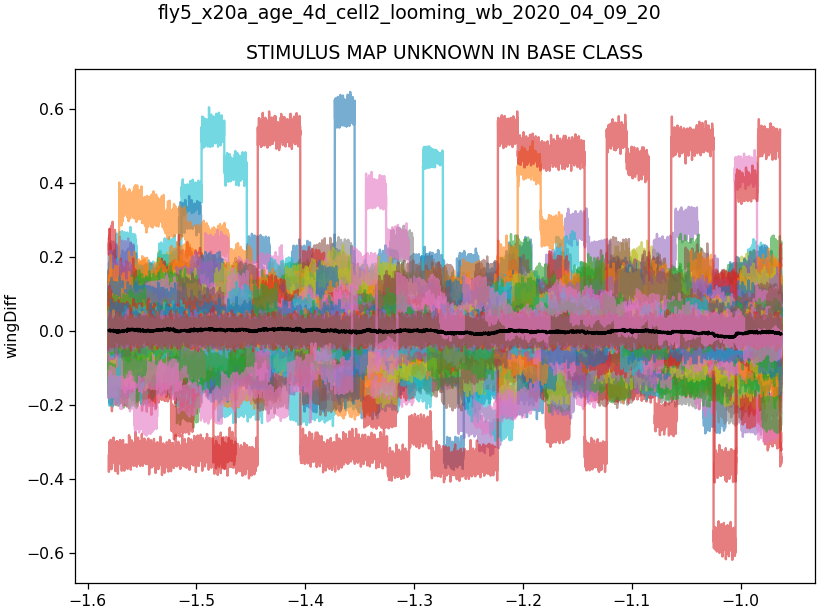

<IPython.core.display.Javascript object>


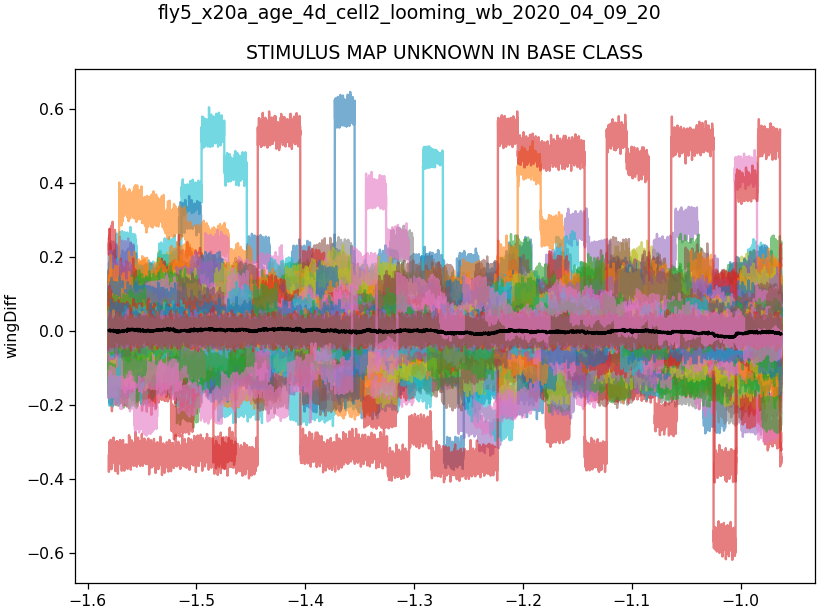

In [44]:
# anlyz.plot_by_stimSignal('ephys')
anlyz.plot_by_stimSignal('wingDiff')
#anlyz.stimulusmap

In [45]:
anlyz.metadata

{0: {'fly': 5,
  'cross': 'x20a',
  'age': 4,
  'cell': 2,
  'stimprotocol': 'looming',
  'year': 2020,
  'month': 4,
  'day': 9,
  'hour': 20,
  'minute': 12,
  'second': 23}}

# Preselect flying trials

That means, the intertrial intervals where the fly was flying. Do it like usual in the other notebook

<IPython.core.display.Javascript object>


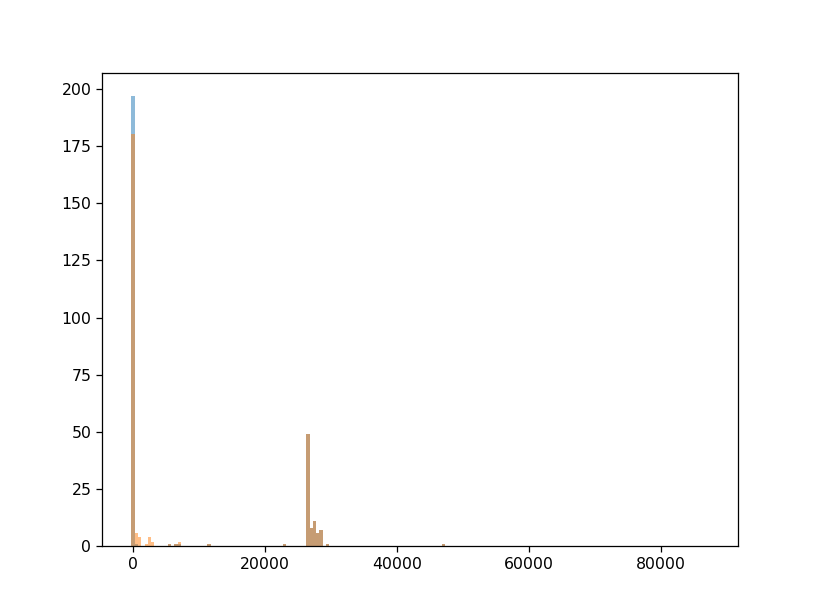

<IPython.core.display.Javascript object>


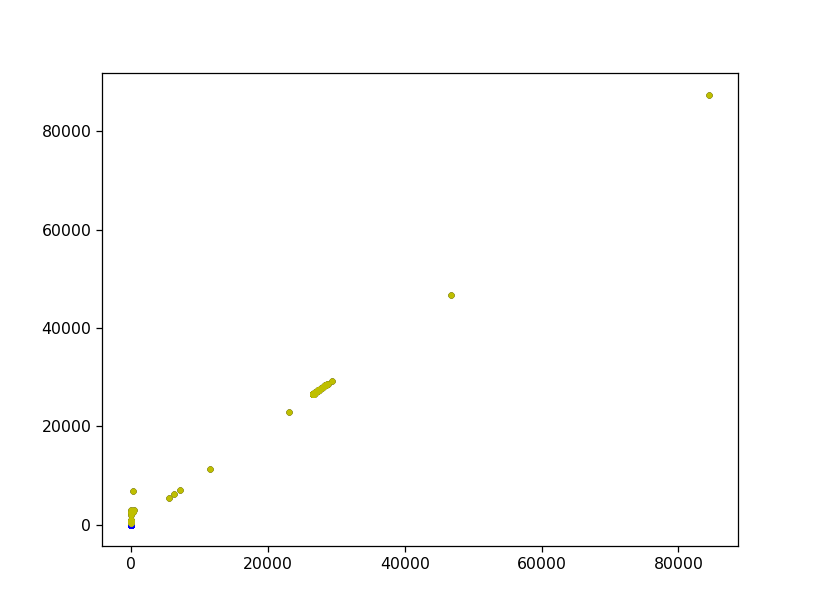

In [46]:
## VERY SIMPLE METHOD, COUNTING THRESHOLDED VALUES AND THRESHOLD THAT
theta = 0.1
f,ax=plt.subplots(1,1)
#t1=np.array([np.sum(np.logical_or(anlyz.segments[i].data[1]>1.6, np.logical_and(anlyz.segments[i].data[1]>-theta, anlyz.segments[i].data[1]<theta))) for i in range(anlyz.segments.size)])
#t2=np.array([np.sum(np.logical_or(anlyz.segments[i].data[2]>1.6, np.logical_and(anlyz.segments[i].data[2]>-theta, anlyz.segments[i].data[2]<theta))) for i in range(anlyz.segments.size)])

t1= np.array([np.sum(np.logical_or(anlyz.segments[i].data[1]>1.6 ,
                                   anlyz.segments[i].data[1]<theta) ) for i in range(anlyz.segments.size)])
#t1= np.array([np.sum(np.logical_and(anlyz.segments[i].data[1]>-theta , anlyz.segments[i].data[1]<theta) ) for i in range(anlyz.segments.size)])
t2= np.array([np.sum(np.logical_or(anlyz.segments[i].data[2]>1.6 ,
                                   anlyz.segments[i].data[2]<theta) ) for i in range(anlyz.segments.size)])
#t2= np.array([np.sum(np.logical_and(anlyz.segments[i].data[2]>-theta , anlyz.segments[i].data[2]<theta) ) for i in range(anlyz.segments.size)])

ax.hist(t1,alpha=0.5, bins=np.arange(-250,t1.max()+250, 500))
ax.hist(t2,alpha=0.5, bins=np.arange(-250,t2.max()+250, 500))

f,ax=plt.subplots(1,1)
jitterForPlotting = np.random.rand(len(t1))/2
ax.plot(t1+jitterForPlotting,  t2,'k.')

In [47]:
# COLORIZE data points (trials) that are (almost) all below threshold (nf=non-flying)
segmentLengths = np.array([s.data.shape[1] for s in anlyz.segments])
discrepancyTol = [max(sl*0.02, 0.05*anlyz.samplingRate) for sl in segmentLengths]
nf = np.where(np.logical_and(np.abs(t1-t2)<0.05*anlyz.samplingRate, t1>anlyz.segments[0].data.shape[1]*0.9))[0]
ax.plot(t1[nf]+jitterForPlotting[nf], t2[nf],'r.')

In [48]:
# COLORIZE data points (trials) that are all above threshold (fl=flying)
fl = np.where(np.logical_and(np.abs(t1-t2)<0.03*anlyz.samplingRate, t1<0.03*anlyz.samplingRate))[0]
#fl = np.where(np.logical_and(np.abs(t1-t2)<0.11*anlyz.samplingRate, t1<0.05*anlyz.samplingRate))[0]
ax.plot(t1[fl]+jitterForPlotting[fl], t2[fl],'b.')

In [49]:
# define junk trials (=jk) as remaining ones, and colorize in plot
jk = np.ones(anlyz.segments.size, dtype=bool)
jk[nf]=False
jk[fl]=False
jk = np.nonzero(jk)[0]
p=plt.plot(t1[jk]+jitterForPlotting[jk], t2[jk],'y.')

In [50]:
print(fl.size)
print(nf.size)
print(jk.size)

181
0
106


In [51]:
#anlyz.remove_duds_byList(jk)
nonflying = nf
flying = fl
toRemove=jk
anlyz.flying[nonflying]=False

In [52]:
targets = [j-np.sum(anlyz.flying[:j]==False) for j in toRemove]

import copy
#saFly = copy.copy(anlyz)
anlyzBAK = copy.copy(anlyz)
# order of operations is important here
anlyz.remove_duds_byList(nonflying)
anlyz.remove_duds_byList(targets)

<IPython.core.display.Javascript object>


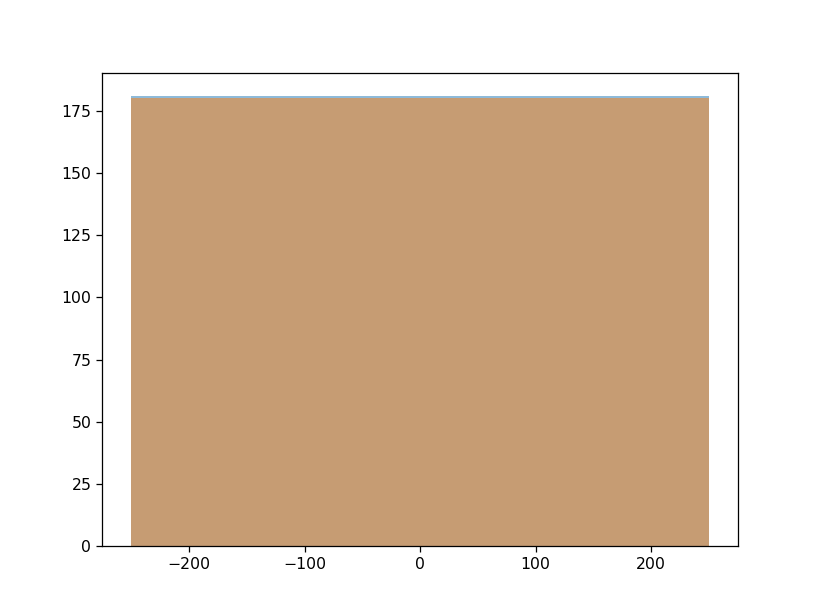

<IPython.core.display.Javascript object>


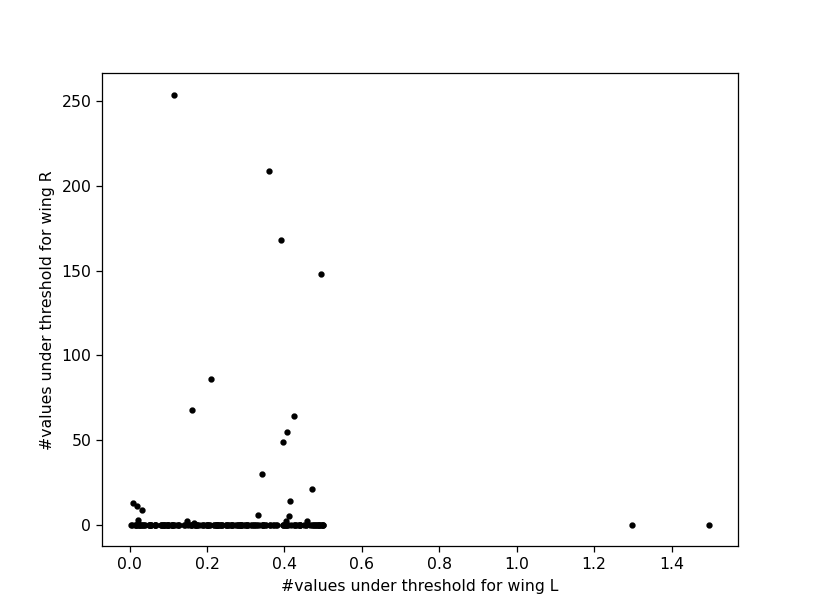

Text(0, 0.5, '#values under threshold for wing R')

In [62]:
## JUST PLOTTING AGAIN TO MAKE SURE EVERYTHING WORKED
#theta = 0.1
f,ax=plt.subplots(1,1)
#t1=np.array([np.sum(np.logical_or(anlyz.segments[i].data[1]>1.6, np.logical_and(anlyz.segments[i].data[1]>-theta, anlyz.segments[i].data[1]<theta))) for i in range(anlyz.segments.size)])
#t2=np.array([np.sum(np.logical_or(anlyz.segments[i].data[2]>1.6, np.logical_and(anlyz.segments[i].data[2]>-theta, anlyz.segments[i].data[2]<theta))) for i in range(anlyz.segments.size)])

t1= np.array([np.sum(np.logical_or(anlyz.segments[i].data[1]>1.6 ,
                                   anlyz.segments[i].data[1]<theta) ) for i in range(anlyz.segments.size)])
#t1= np.array([np.sum(np.logical_and(anlyz.segments[i].data[1]>-theta , anlyz.segments[i].data[1]<theta) ) for i in range(anlyz.segments.size)])
t2= np.array([np.sum(np.logical_or(anlyz.segments[i].data[2]>1.6 ,
                                   anlyz.segments[i].data[2]<theta) ) for i in range(anlyz.segments.size)])
#t2= np.array([np.sum(np.logical_and(anlyz.segments[i].data[2]>-theta , anlyz.segments[i].data[2]<theta) ) for i in range(anlyz.segments.size)])

ax.hist(t1,alpha=0.5, bins=np.arange(-250,t1.max()+250, 500))
ax.hist(t2,alpha=0.5, bins=np.arange(-250,t2.max()+250, 500))

f,ax=plt.subplots(1,1)
jitterForPlotting = np.random.rand(len(t1))/2
ax.plot(t1+jitterForPlotting,  t2,'k.')
ax.set_xlabel('#values under threshold for wing L')
ax.set_ylabel('#values under threshold for wing R')

# Detect Saccades

## begin by fitting the PWC wingdiff

<IPython.core.display.Javascript object>


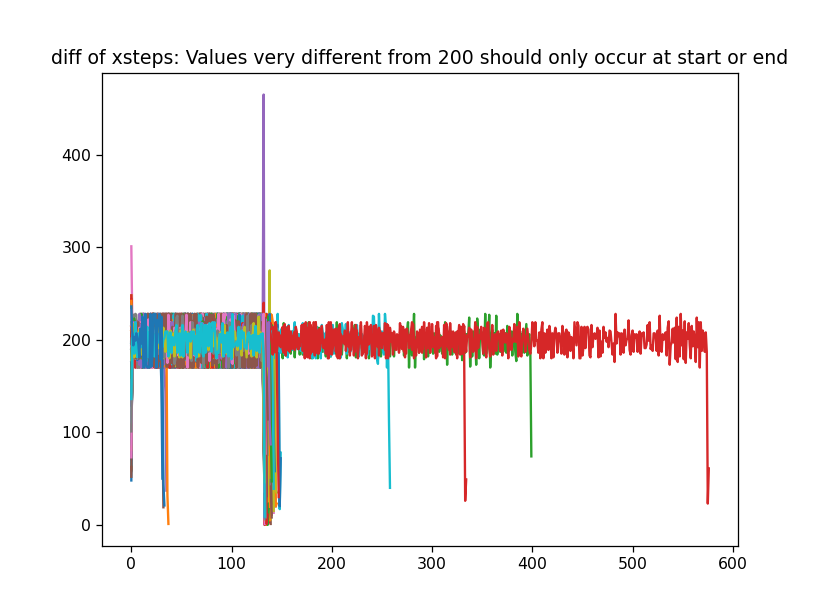

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean o

Text(0.5, 1.0, 'diff of xsteps: Values very different from 200 should only occur at start or end')

In [63]:
import helperLibrary

res={}
f,ax=plt.subplots(1,1)
for i,seg in enumerate(anlyz.segments):
    yfit, xsteps, ysteps = helperLibrary.straightLineFiltering(seg.data[anlyz.channelmap['wingDiff']], 0.020*anlyz.samplingRate, postEnhancement=True)
    res[i] = ysteps
    ax.plot(np.diff(xsteps))
ax.set_title('diff of xsteps: Values very different from 200 should only occur at start or end')

In [64]:
pureYvals = res

In [20]:
# use the central difference
def central_diff_derivative(y, halfwidth=0.070, samplPeriod=0.020):
    """y is data to derivate, assumed to be np.array
    halfwidth and samplPeriod shall use the same unit (e.g. seconds)"""
    stepBack = int(halfwidth/samplPeriod+0.5)
    stepFwd = int(halfwidth/samplPeriod)
    return ( y[(stepFwd+stepBack):]-y[:-(stepBack+stepFwd)] )/((stepFwd+stepBack)*samplPeriod)

In [40]:
#central derivative on PWC signal
detectSignal = [central_diff_derivative(v, 0.11, 0.02) for k,v in pureYvals.items()]

In [41]:
import ipywidgets
import plotly.graph_objects as go
slider = ipywidgets.IntSlider(min=0, max=len(detectSignal)-1)
trace1 = go.Scatter(y=pureYvals[0])
trace2 = go.Scatter(y=detectSignal[0])
"""fig = go.FigureWidget(data=[trace1, trace2],
            layout=go.Layout(
                title=dict(
                    text='filtered and differentiated signals') ))
def react(change):
    idx = slider.value
    fig.data[0].y = pureYvals[idx]
    fig.data[1].y = detectSignal[idx]
    return
"""
fig1 = go.FigureWidget(data=[trace1],
            layout=go.Layout(
                title=dict(text='filtered signals') ))
fig2 = go.FigureWidget(data=[trace2],
            layout=go.Layout(
                title=dict(text='differentiated signals') ))
def react(change):
    idx = slider.value
    fig1.data[0].y = pureYvals[idx]
    fig2.data[0].y = detectSignal[idx]
    return

slider.observe(react, names='value')
container = ipywidgets.widgets.HBox([slider])
ipywidgets.widgets.VBox([container,
              fig1,fig2])

    'data': [{'type': 'scatter',
 …

## detection from Kim et al 2015

Work on raw signal, although at least for the lowpass filter it does not make a difference, not in quality, not even in quantity

### comparison raw and step-fitted data

<IPython.core.display.Javascript object>


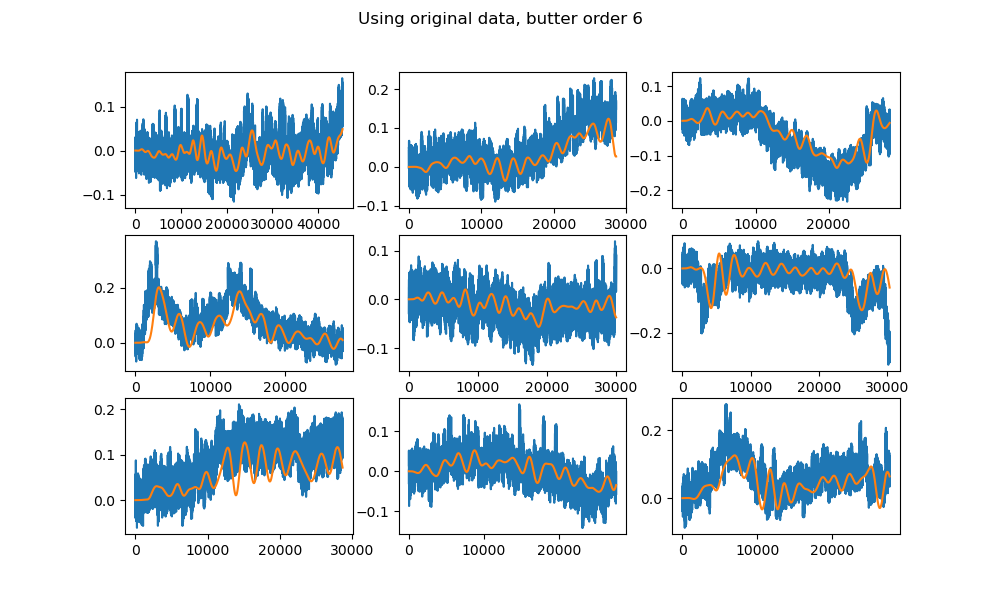

<IPython.core.display.Javascript object>


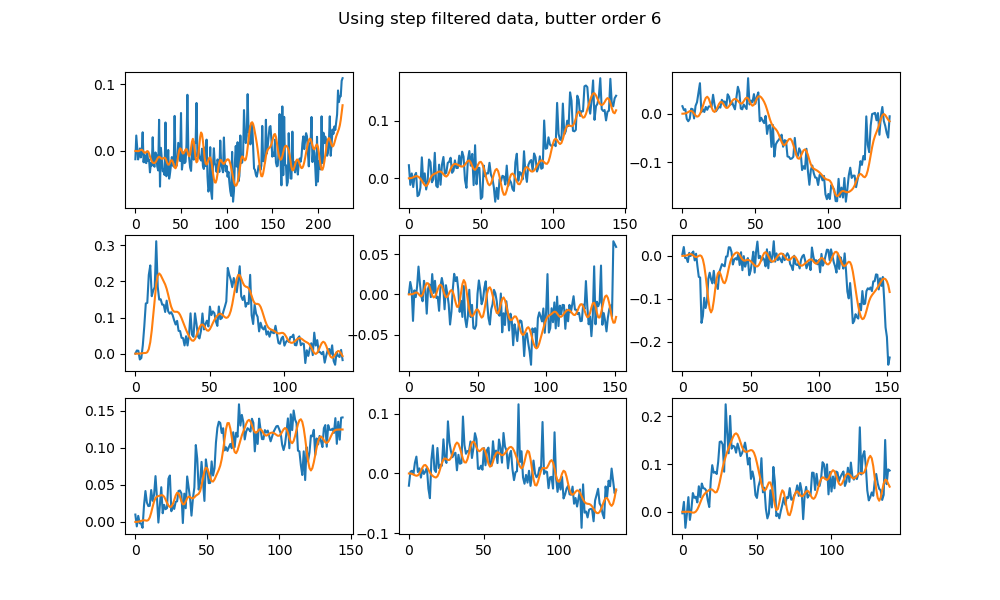

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Using step filtered data, butter order 6')

In [24]:
# lowpass filter wingDiff with 6Hz
f,ax=plt.subplots(3,3, figsize=(10,6))
ax=ax.flatten()
for i,seg in enumerate(anlyz.segments[:9]):
    y=seg.data[anlyz.channelmap['wingDiff']]
    b,a=signal.butter(6,6.,fs=anlyz.samplingRate, btype='low')
    ylow = signal.lfilter(b,a,y)
    ax[i].plot(y)
    ax[i].plot(ylow)
f.suptitle('Using original data, butter order 6')

#comparison to previously step-filtered result
import helperLibrary
f,ax=plt.subplots(3,3, figsize=(10,6))
ax=ax.flatten()
for i,seg in enumerate(anlyz.segments[:9]):
    _,_,y = helperLibrary.straightLineFiltering(seg.data[anlyz.channelmap['wingDiff']],  0.020*anlyz.samplingRate, postEnhancement=True)
    b,a=signal.butter(6,6.,fs=50., btype='low')
    ylow = signal.lfilter(b,a,y)
    ax[i].plot(y)
    ax[i].plot(ylow)
f.suptitle('Using step filtered data, butter order 6')

### begin by low-pass filering

In [35]:
el=0
y = anlyz.segments[el].data[anlyz.channelmap['wingDiff']]
samplingRate = anlyz.samplingRate

In [65]:
def lowPass(y, samplingRate):
    fThresh = 6.#Hz
    #b,a=signal.butter(5,6.,fs=samplingRate, btype='low')
    #ylow = signal.lfilter(b,a,y)
    b,a=signal.butter(5,6.*1.5,fs=samplingRate, btype='low')
    ylow = signal.filtfilt(b,a,y)
    return ylow

### derivation using central differential

In [66]:
def central_diff_derivative(y, halfwidth=0.070, samplPeriod=0.020):
    """y is data to derivate, assumed to be np.array
    halfwidth and samplPeriod shall use the same unit (e.g. seconds)"""
    stepBack = int(halfwidth/samplPeriod+0.5)
    stepFwd = int(halfwidth/samplPeriod)
    return ( y[(stepFwd+stepBack):]-y[:-(stepBack+stepFwd)] )/((stepFwd+stepBack)*samplPeriod)

In [43]:
# compare "normal" derivative to central difference
ylow = lowPass(y,samplingRate)
f,ax=plt.subplots(1,1)
halfwidth=[0.07, 0.04,0.02]
for hw in halfwidth:
    ax.plot(np.arange(int(hw*samplingRate),int(ylow.size-hw*samplingRate)), central_diff_derivative(ylow, halfwidth=hw, samplPeriod=1/anlyz.samplingRate))
ax.plot(np.diff(ylow)*samplingRate)

NameError: name 'lowPass' is not defined

In [ ]:
# stick to 70 ms halfwidth anyways for comparability
ydiff = central_diff_derivative(ylow, halfwidth=0.07, samplPeriod=1/samplingRate)

#### extract fly statistics

In [67]:
def highpass_data(y, samplingRate):
    # highpass data
    b,a = signal.butter(5, 1., fs=samplingRate, btype='high')
    yhigh = signal.lfilter(b,a,y)
    return yhigh

def plotHighLowPass(y, yhigh, ylow=None):
    f,ax=plt.subplots(1,1)
    ax.plot(y)
    ax.plot(yhigh)
    if not ylow is None:
        ax.plot(ylow)
    ax.legend(['original','highpass', 'lowpass'])
    return ax

In [68]:
def extractFlyStatistics(y, samplingRate, plot=True, **kwargs):
    yhigh = highpass_data(y, samplingRate)
    pdf, bins = np.histogram(yhigh, bins=50)
    pdf = pdf/pdf.sum()
    cdf = np.cumsum(pdf)
    thresh = kwargs.get('thresh',0.95)
    binCenters = (bins[:-1]+bins[1:])/2

    minIdx = np.argmin(np.abs(cdf-thresh))
    theta = binCenters[minIdx]
    
    if plot:
        f,ax=plt.subplots(1,1)
        ax.plot(binCenters, pdf)
        ax.plot(binCenters, cdf)
        ax.plot(binCenters[minIdx],cdf[minIdx], 'go')
        ax.plot(binCenters[minIdx],pdf[minIdx], 'ro')
        ax.axhline(0.9, color='k', linestyle=':')
        ax.axvline(theta, color='r')
    return theta

### detect

In [69]:
def detectPeaks(theta, ydiff):
    detectTheta = theta*6. #as stated in paper
    peaksFound = signal.find_peaks(np.abs(ydiff), height=detectTheta)
    return peaksFound

In [70]:
def plotDetection(ax,ydiff, detectTheta):
    #ax=plt.gca()
    #ax.plot(np.abs(ydiff))
    ax.plot(ydiff)
    ax.axhline(detectTheta, color='k')    
    ax.axhline(0, color='g')

### find peak and onset times

Putative saccades were isolated from the derivative trace by first finding local maxima and minima that exceeded a threshold tailored to the wingstroke statistics of each fly.

For each putative saccade, we determined an onset time and a peak time. The peak time of the saccade was mapped to the point in time at which the derivative signal returned to 0 after the local maximum/minimum. 

A putative onset time was mapped to the point in time at which the derivative signal returned to zero before the local min/max. 

Because the derivative signal is long-pass filtered, without further correction this onset time approximation was earlier relative to the actual onset. To correct for this error, we found the sample in the low-pass filtered L-R WBA trace that corresponded to the point in time of the putative onset time, which we considered a threshold; we then looked forward in time in the unfiltered L-R WBA trace for the last sample before this threshold was crossed, which was used to define the actual onset time. 

To measure saccade amplitude, we subtracted the mean L-R WBA signal in a 50-ms baseline interval immediately before saccade onset from the mean L-R WBA signal in a +-15-ms windows surrounding the peak.

#### peak time

In [71]:
# find peak times
def findPeakTimes(ydiff, peaksFound):
    ## for each peak, move FORWARD till encountering closest to 0
    peakTime = np.full_like(peaksFound, np.nan, dtype=int)
    for j,p in enumerate(peaksFound):
        #compare the signs, because peaks can be + or - (at 0 it switches)
        sameSign = True
        i=0
        while sameSign>0:
            i+=1
            if p+i >=ydiff.size:
                i -=1 #plug right value for line after while loop
                break
            sameSign = (ydiff[p+i]*ydiff[p+i-1])>0. 
        if p+i <ydiff.size:
            thisPeak = p+i-1 + np.argmin(np.abs(ydiff[[p+i-1,p+i]]))
        else:
            thisPeak = ydiff.size
        #print(ydiff[[p+i-1,p+i]])
        #print(thisPeak)
        peakTime[j] = int(thisPeak)
    return peakTime

#### onset time

In [72]:
# find onset times
def findOnsetTime(ydiff, peaksFound):
    ## for each peak, move BACKWARD till encountering closest to 0
    onsetTime = np.zeros_like(peaksFound, dtype=int)
    for j,p in enumerate(peaksFound):
        sameSign = True
        i=-0
        while sameSign>0:
            i-=1
            if p+i<0:
                i+=1 #plug right value for line after while loop
                break
            sameSign = (ydiff[p+i]*ydiff[p+i+1])>0. #compare the signs, because peaks can be + or - (at 0 it switches)
        if p+i >=0:
            thisOnset = p+i + np.argmin(np.abs(ydiff[[p+i,p+i+1]]))
        else:
            thisOnset=0
        #print(ydiff[[p+i,p+i+1]])
        #print(thisOnset)
        onsetTime[j] = int(thisOnset)
    return onsetTime

#### corrected onset time

In [73]:
# correct onset times for error introduced by lowpass filtering
def correctOnsetTime(y,ylow, ydiff, peaksFound, onsetTime):
    actualOnset = np.full_like(onsetTime, np.nan, dtype=int)
    for j,o in enumerate(onsetTime):
        ## use value of low-passed L-R WBA at putative onset as threshold
        thresh = ylow[o]
        ## look forward in original signal from putative onset and find last sample before threshold
        ytemp = y-thresh #this turns it into finding a 0-crossing (like above)
        ### shortcut to deal with cases where actual onset is not included in trace
        p = peaksFound[j]
        if not any(np.diff(np.sign(ytemp[o:p]))):
            #no change in sign means no threshold crossing
            actualOnset[j] = o #keep putataive one
            continue
        sameSign=True
        i=0
        while sameSign:
            i+=1
            #sameSign = (ydiff[o+i]*ydiff[o+i-1])>0.
            sameSign = (ytemp[o+i]*ytemp[o+i-1])>0.
        ## define this as actual onset
        actualOnset[j] = o+1-1
    return actualOnset

#### saccade amplitude

In [74]:
## get saccade amplitudes
def getSaccadeAmplitude(y, peaksFound, actualOnset, samplingRate):
    #subtracted the mean L-R WBA signal 50-ms baseline interval before saccade onset 
    #from mean L-R WBA signal in +-15-ms windows surrounding the peak
    saccAmp = np.full(peaksFound.size, np.nan, dtype=np.float)
    for i in range(len(actualOnset)):
        baseline = np.mean(y[actualOnset[i]-int(0.06*samplingRate) : actualOnset[i]])
        if not np.isnan(baseline):
            #saccAmp[i] =  np.mean( y[peaksFound[i]-int(0.03*samplingRate) : peaksFound[i]+int(0.03*samplingRate)+1] ) - baseline    
            saccAmp[i] =  np.mean( y[peaksFound[i]-int(0.03*samplingRate) : peaksFound[i]+int(0.03*samplingRate)] ) - baseline    
    return saccAmp

In [75]:
def plotPeaks(y, actualOnset, peakTime, saccAmp, ax=None):
    if ax is None:
        f,ax=plt.subplots(1,1)
        ax.plot(y)
    ax.plot(actualOnset, y[actualOnset], 'r>')
    ax.plot(peakTime, y[peakTime], 'k^')
    ax.plot(peakTime, saccAmp, 'ko')
    return

### eliminate flawed detections

If two or more saccades occurred in close succession, the end of one saccade could overlap with the onset of the next. Even with isolated saccades, the algorithm would typically detect the rising and falling phases of putative events as two potential saccades. 

To deal with both of the above issues, we measured the maximum deviation of L-R WBA in the 200 ms preceeding saccade onset and eliminated putative saccades in which this value exceeded 55% of saccade amplitude. 

We also excluded tonic/persistent turns -- which are not traditional saccades -- from further consideration. A putative saccade was defined as a persistent turn if the L-R WBA signal stayed more than 45% above baseline for >700 ms after the peak

In [76]:
# eliminate putative saccade if maximal deviation before onset is>55% of amplitude
def eliminateByDeviation(y, actualOnset, saccAmp, samplingRate, **kwargs):
    window = kwargs.get('window',0.201)
    deviationLimit = kwargs.get('deviationLimit',0.55)
    toEliminate = []
    for i in range(actualOnset.size):
        # preselect to make sure the indexing is feasible
        #baseline = np.mean(y[actualOnset[i]-int(0.2*samplingRate) : actualOnset[i]])
        chunk = y[actualOnset[i]-int(window*samplingRate) : actualOnset[i]]
        if actualOnset[i]-int(window*samplingRate) <0:
            toEliminate.append(i)
            continue
        deviation = chunk.max()-chunk.min()
        if deviation>deviationLimit*abs(saccAmp[i]):
            toEliminate.append(i)
    return toEliminate


In [46]:
eliminateByDeviation(y,actualOnset)

NameError: name 'y' is not defined

In [47]:
# eliminate persistent turns
## which baseline? how to compare without falling into trap of comparing to the next saccade

### putting this together

<IPython.core.display.Javascript object>


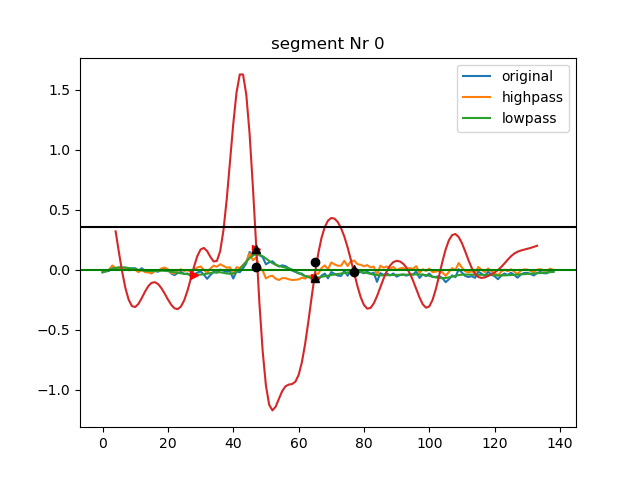

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


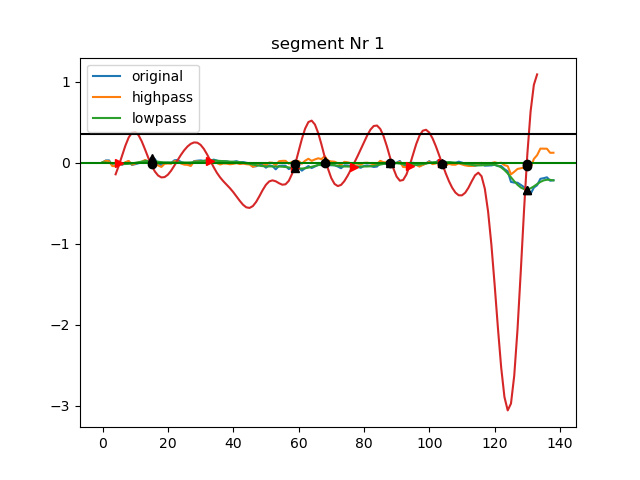

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


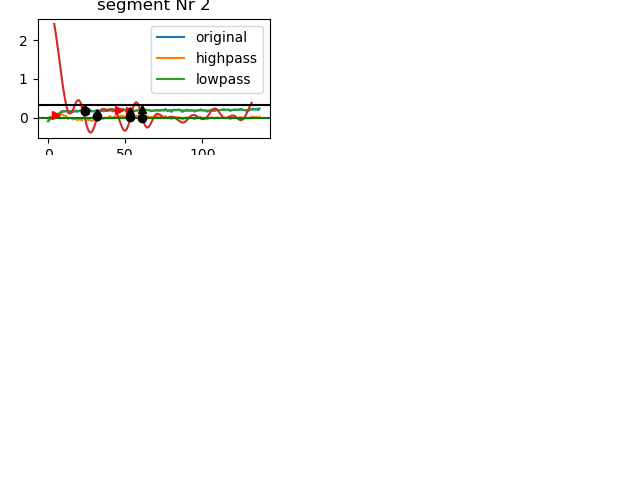

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


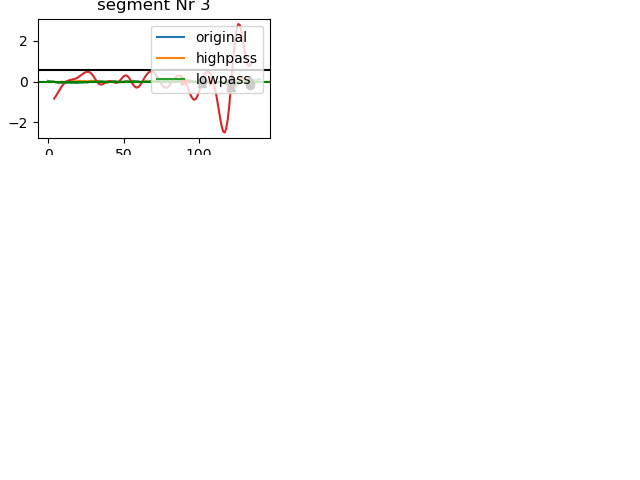

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


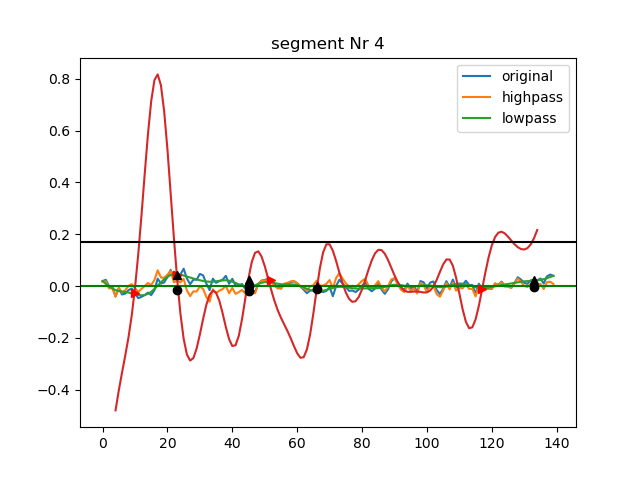

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


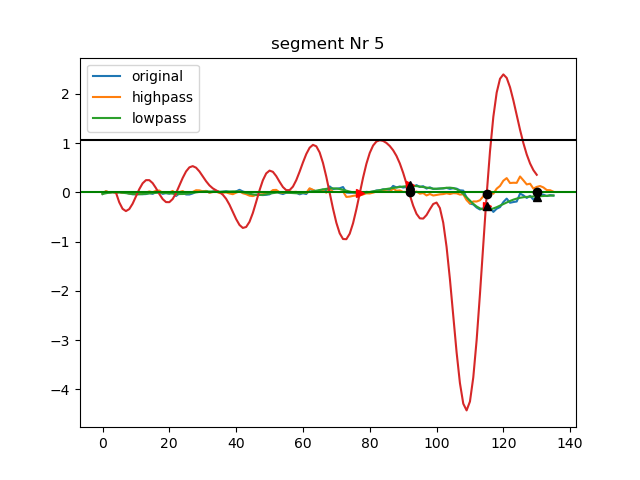

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


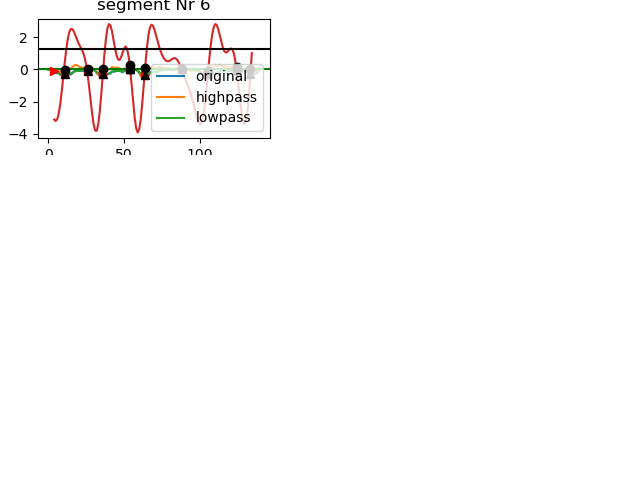

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


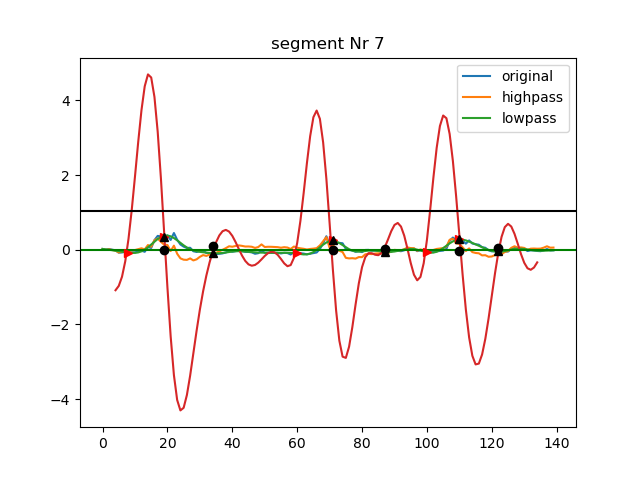

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


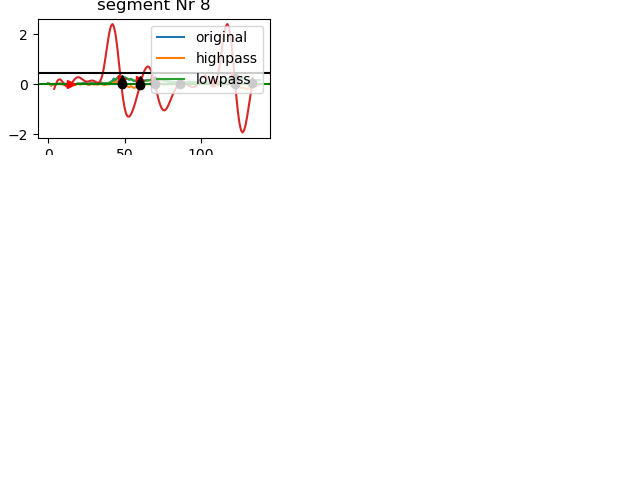

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


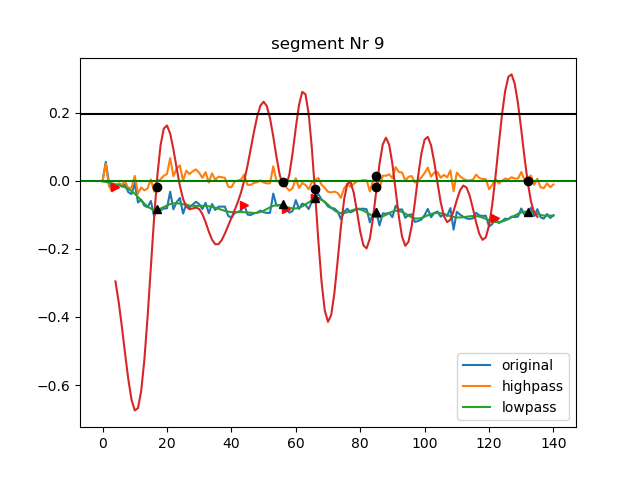

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


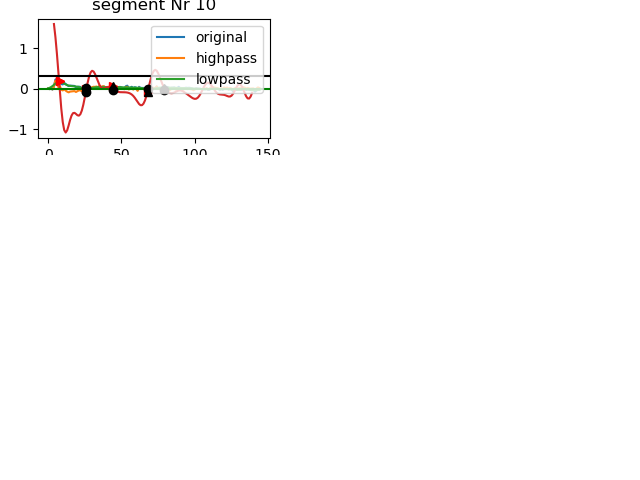

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume t

<IPython.core.display.Javascript object>


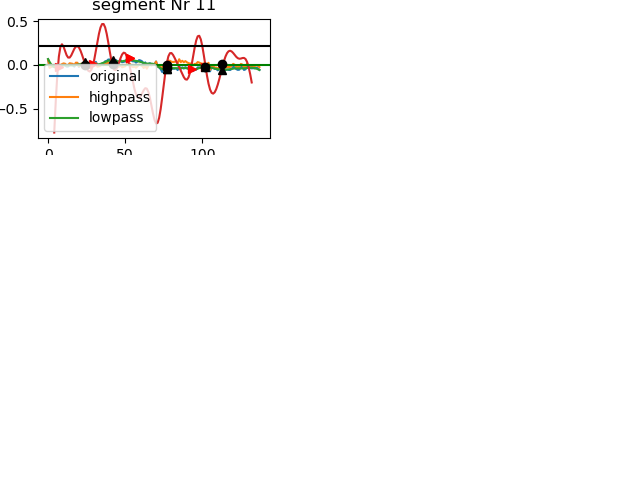

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


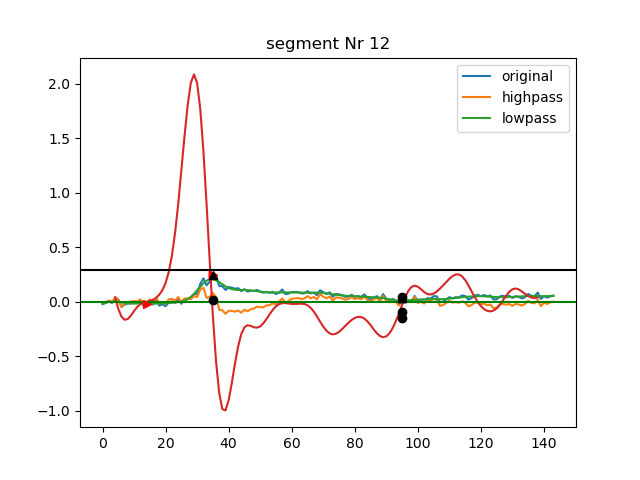

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


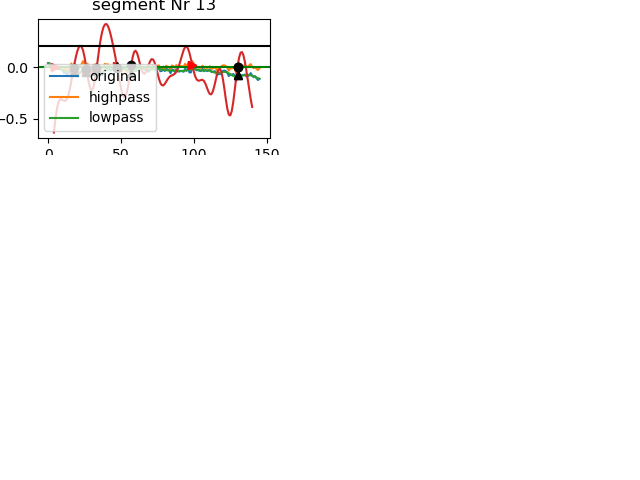

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


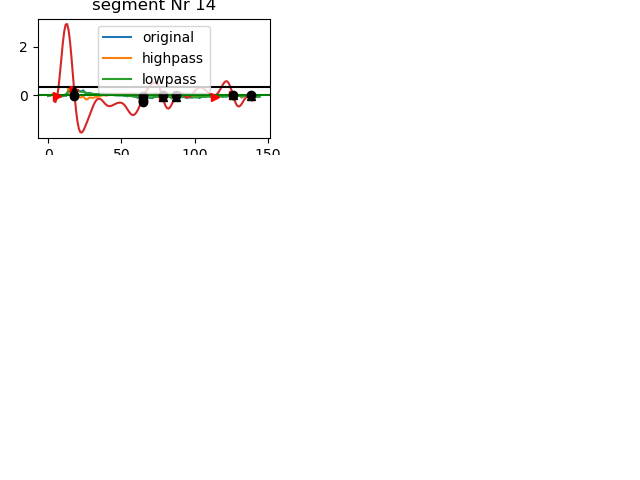

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


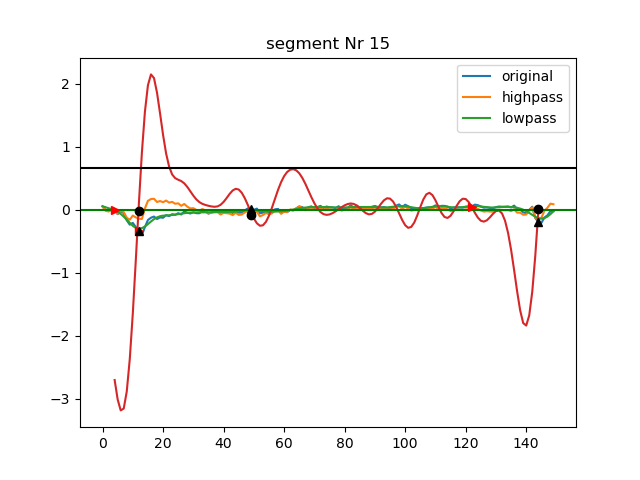

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


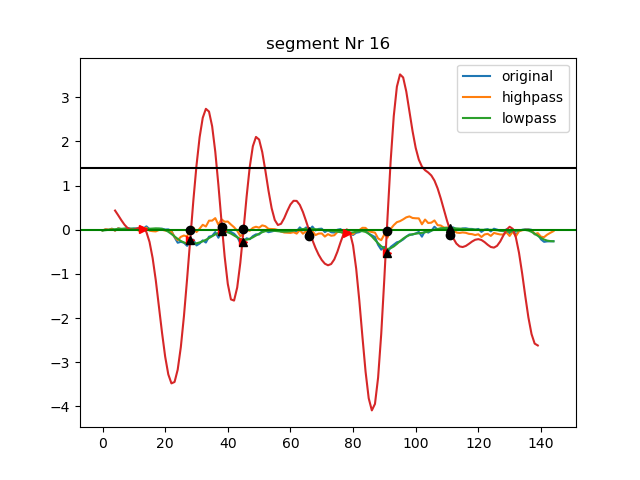

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


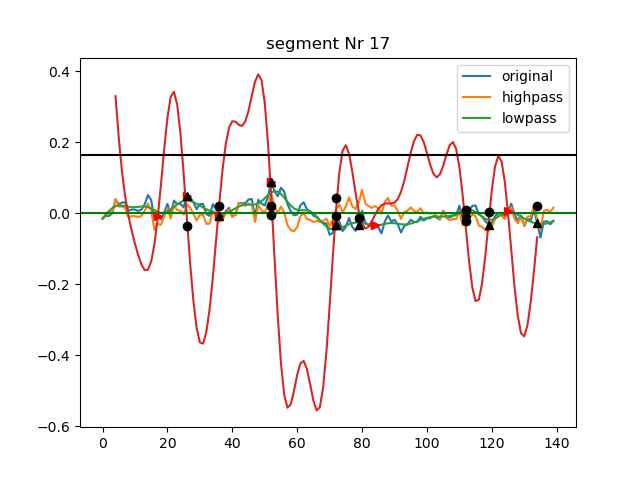

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


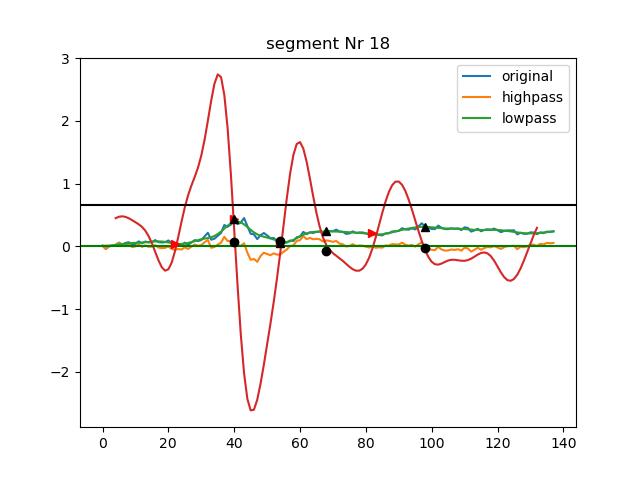

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


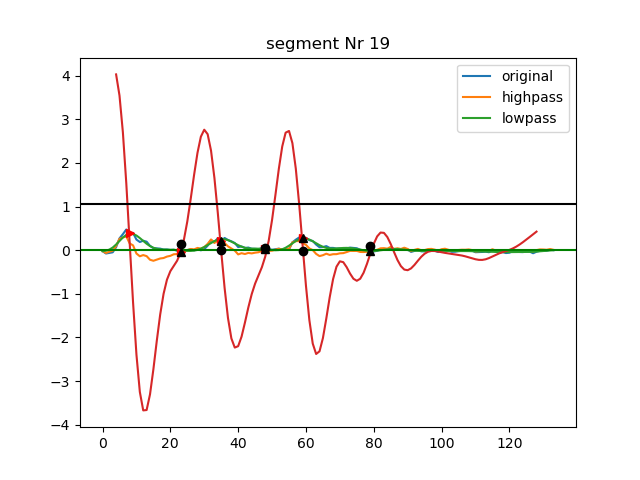

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


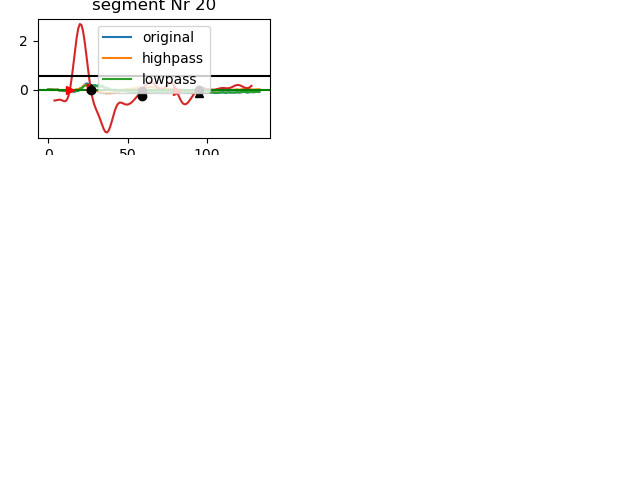

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


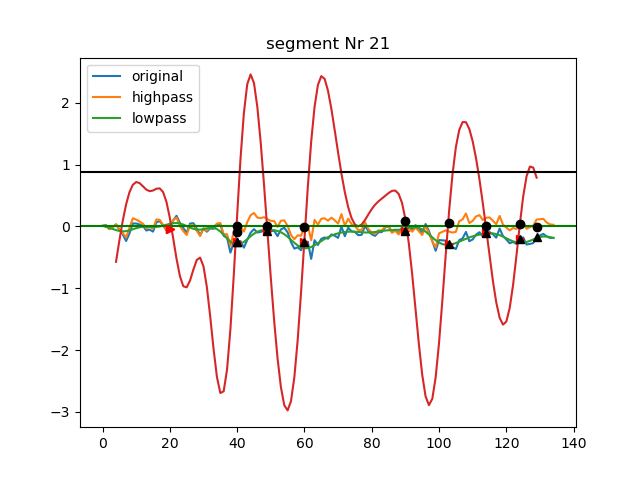

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


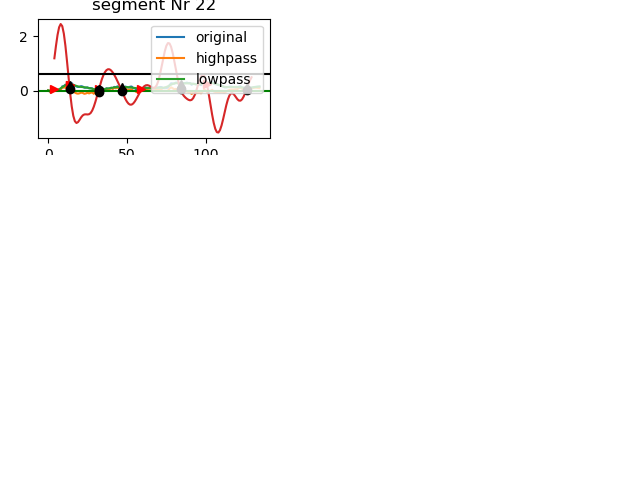

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


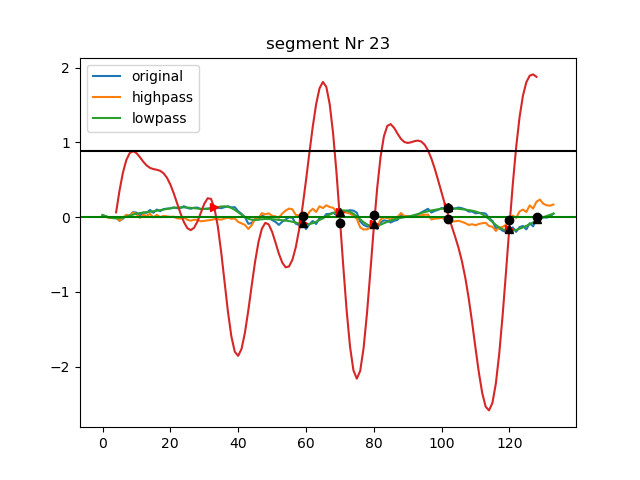

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


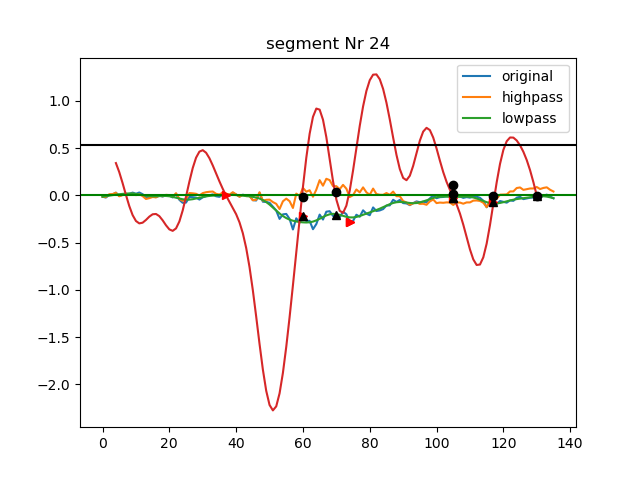

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


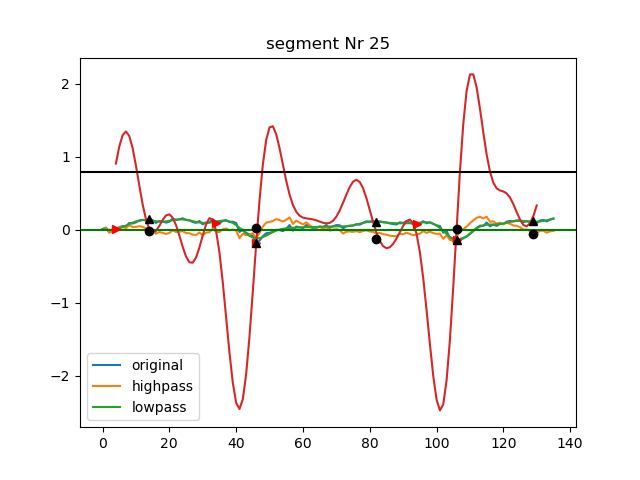

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


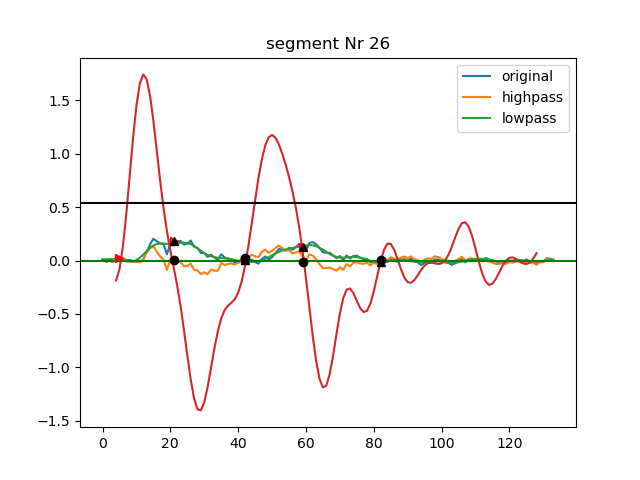

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


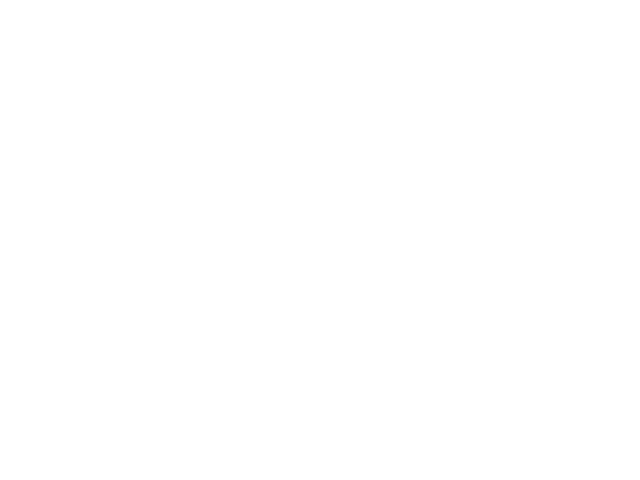

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


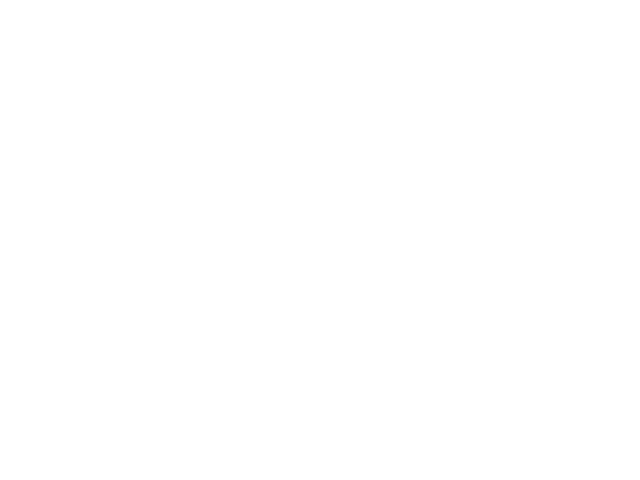

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


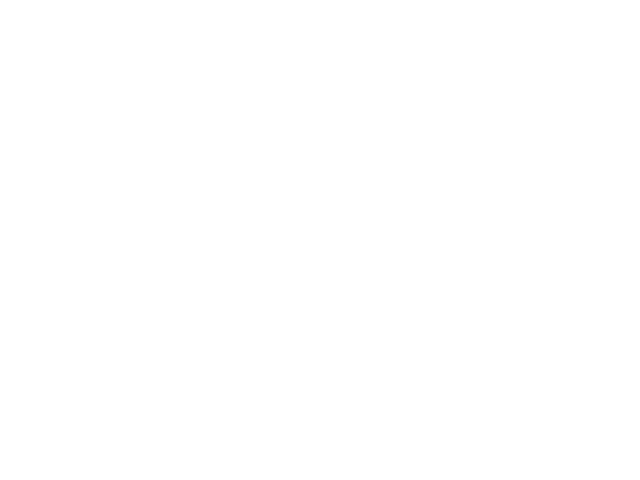

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


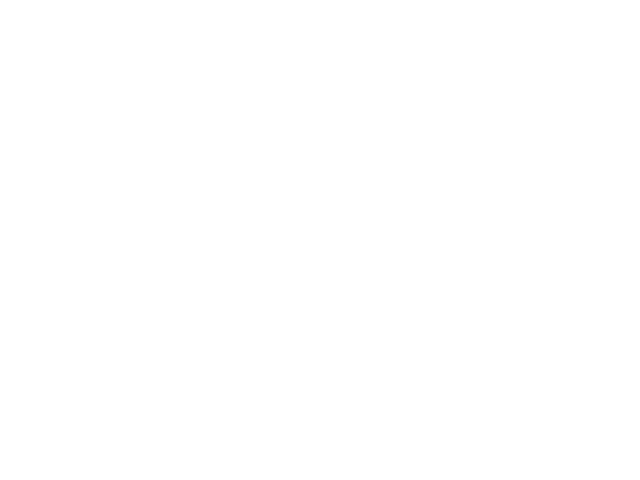

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


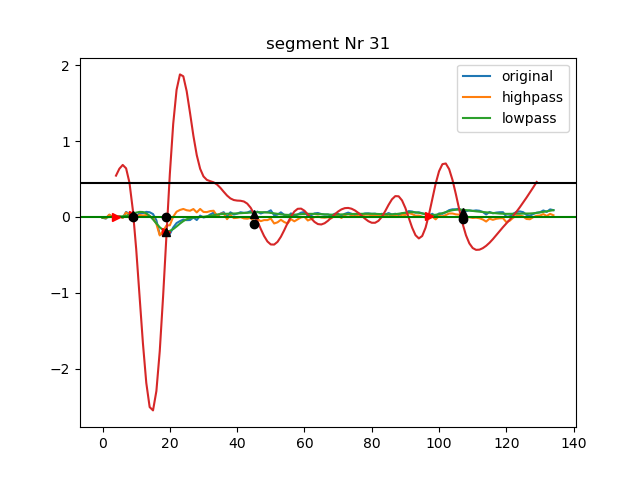

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


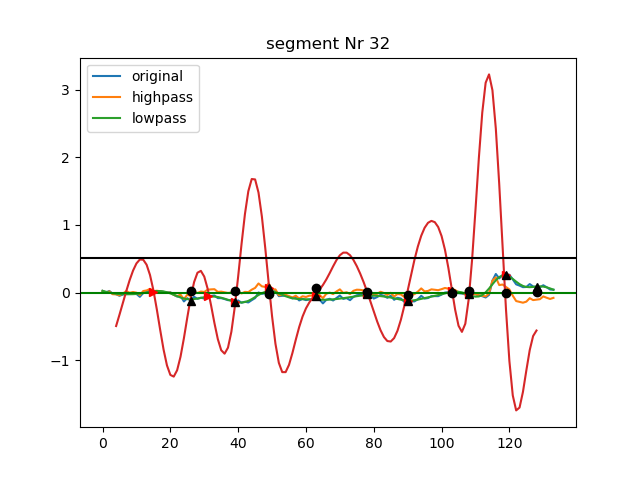

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


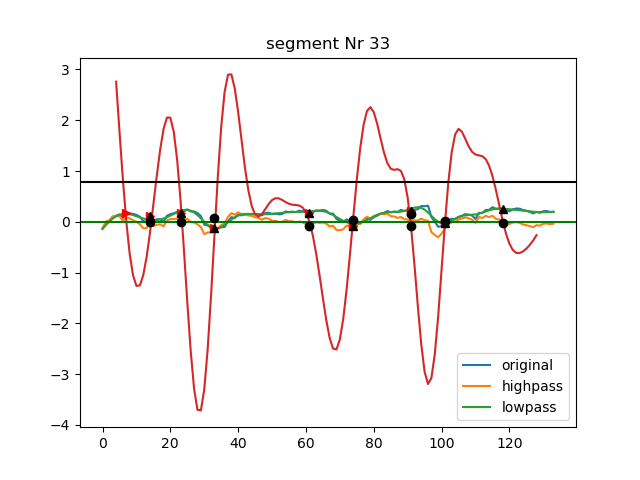

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


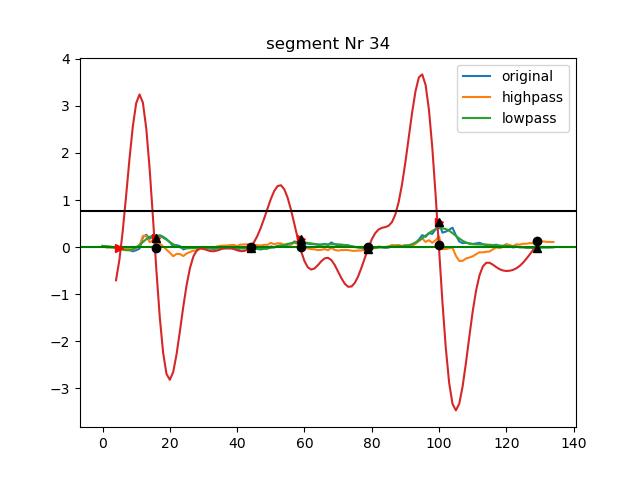

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


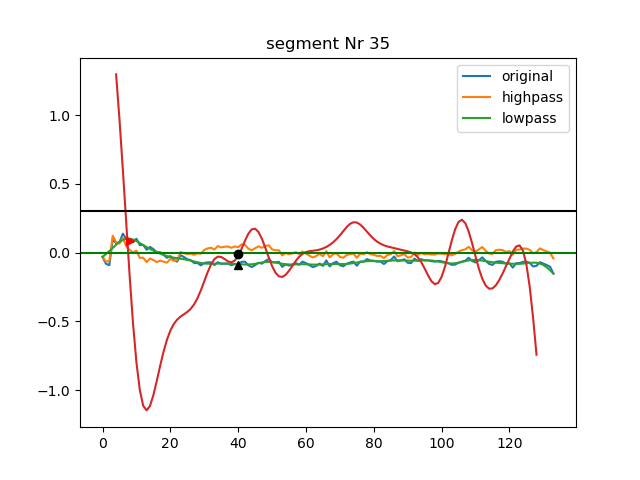

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


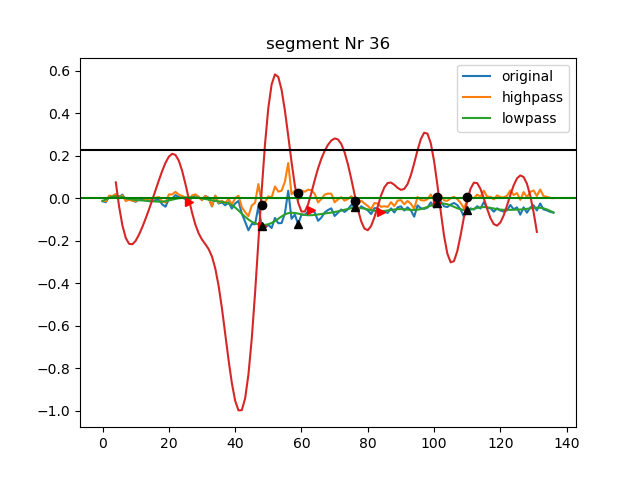

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


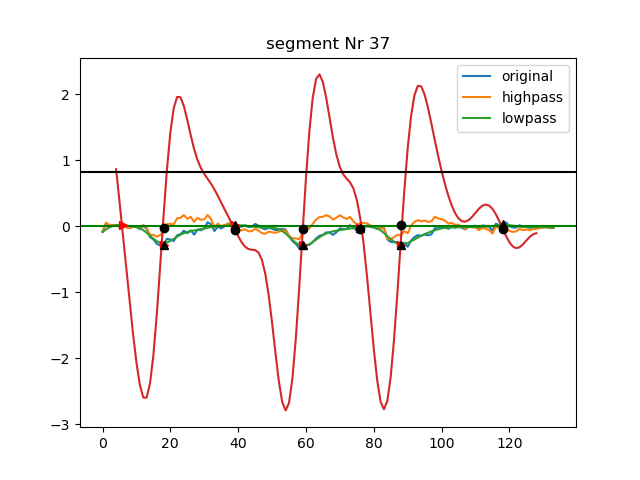

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<IPython.core.display.Javascript object>


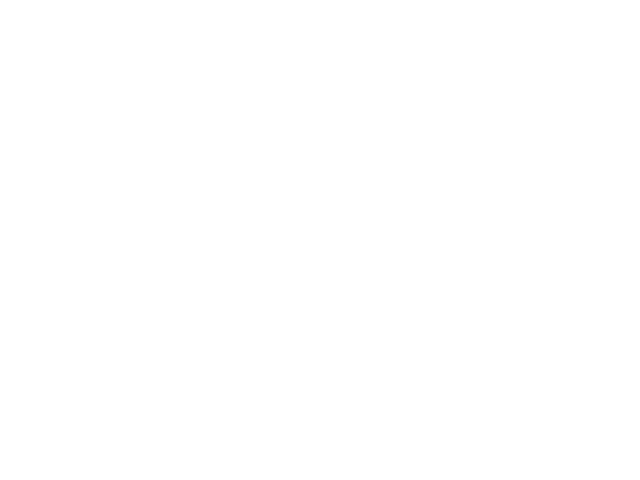

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [63]:
saccData = {}
#el=1
for el in range(anlyz.segments.size):
#for el in range(2,3):
    #y = anlyz.segments[el].data[-1]
    #samplingRate = anlyz.samplingRate
    y=pureYvals[el]
    samplingRate = 1/anlyz.meanFramePeriod
    h=0.050

    ylow = lowPass(y,samplingRate)
    yhigh = highpass_data(y, samplingRate)
    ydiff = central_diff_derivative(ylow, halfwidth=h, samplPeriod=1/samplingRate)
    ax = plotHighLowPass(y, yhigh, ylow)
    theta = extractFlyStatistics(y, samplingRate, ylow, plot=False)
    peaksFound = detectPeaks(theta, ydiff)[0]
    plotDetection(ax,np.concatenate((np.full(int(h*samplingRate), np.nan),
        ydiff#, np.full(int(h*samplingRate), np.nan)
                                    )), theta*6)
    peakTime = findPeakTimes(ydiff, peaksFound)
    onsetTime = findOnsetTime(ydiff, peaksFound)
    #peaksFound = peaksFound + int(h*samplingRate)-3#correct for bias by central_difference
    peakTime += int(h*samplingRate)    
    onsetTime += int(h*samplingRate)
    #actualOnset = correctOnsetTime(y,ylow, ydiff, peaksFound, onsetTime)
    #ypwc, _,_ = helperLibrary.straightLineFiltering(y, 0.020*samplingRate, postEnhancement=True)
    actualOnset = correctOnsetTime(y,ylow, ydiff, peakTime, onsetTime)
    saccAmp = getSaccadeAmplitude(y, actualOnset, samplingRate)
    #plotPeaks(y,actualOnset, peakTime, saccAmp)
    plotPeaks(y,actualOnset, peakTime, saccAmp, ax)
    ax.set_title(f'segment Nr {el}')
    
    saccData[el] = dict([('peakTime',peakTime),('actualOnset',actualOnset), ('saccAmp',saccAmp)])

In [66]:
print(saccData)

{0: {'peakTime': array([47, 65, 77], dtype=int64), 'actualOnset': array([28, 47, 65], dtype=int64), 'saccAmp': array([ 0.02237382,  0.06398268, -0.02213237])}, 1: {'peakTime': array([ 15,  59,  68,  88, 104, 130, 130], dtype=int64), 'actualOnset': array([  5,  33,  59,  77,  94, 104, 104], dtype=int64), 'saccAmp': array([-0.00857127, -0.0116698 , -0.00700188, -0.00627755, -0.00772621,
       -0.01456713, -0.04241368])}, 2: {'peakTime': array([24, 32, 53, 61], dtype=int64), 'actualOnset': array([ 5, 24, 46, 53], dtype=int64), 'saccAmp': array([ 0.15738128,  0.0463975 ,  0.00543249, -0.00756525])}, 3: {'peakTime': array([102, 121, 134], dtype=int64), 'actualOnset': array([ 91, 109, 121], dtype=int64), 'saccAmp': array([ 0.00466792, -0.01702181, -0.16241136])}, 4: {'peakTime': array([ 23,  45,  45,  66, 133], dtype=int64), 'actualOnset': array([ 10,  23,  23,  52, 117], dtype=int64), 'saccAmp': array([-0.01665964,  0.00032193, -0.01915456, -0.01243437, -0.00515081])}, 5: {'peakTime': arra

In [67]:
f,ax=plt.subplots(1,1)
temp=ylow
ax.plot(temp/temp.max(), '-x')
temp=np.diff(ylow)
ax.plot(temp/temp.max(), '-x')
temp = central_diff_derivative(ylow, 0.0001, 1/samplingRate)
ax.plot(temp/temp.max(), '-x')
temp = central_diff_derivative(ylow, 0.0002, 1/samplingRate)
ax.plot(temp/temp.max(), '-x')
temp = central_diff_derivative(ylow, 0.001, 1/samplingRate)
ax.plot(temp/temp.max(), '-x')

<IPython.core.display.Javascript object>

ValueError: operands could not be broadcast together with shapes (23,) (0,) 

## Cut out saccade episodes

And of course overlay, make a plot for inspection of overall results

In [101]:
for el,v in saccData.items():
#for el in [9]:
    v = saccData[el]
    actualOnset= v['actualOnset']
    saccAmp = v['saccAmp']
    rightSacc = []
    leftSacc=[]
    chunk = int(0.5*anlyz.samplingRate)
    preOnset = int(0.1*anlyz.samplingRate)
    ephys = anlyz.segments[el].data[0]#ephys data
    wba = anlyz.segments[el].data[-1]
    f,ax=plt.subplots(2,2)
    for o,a in zip(actualOnset, saccAmp):
        if a<0:
            leftSacc.append(ephys[o-preOnset:o+chunk])
            ax[0,1].plot(wba[o-preOnset:o+chunk])#have to adjust this for PWC-fitted data
            ax[1,1].plot(ephys[o-preOnset:o+chunk])
        else:
            rightSacc.append(ephys[o-preOnset:o+chunk])
            ax[0,0].plot(wba[o-preOnset:o+chunk])#have to adjust this for PWC-fitted data
            ax[1,0].plot(ephys[o-preOnset:o+chunk])
    ax[0,0].set_title('saccades to right')
    ax[0,1].set_title('saccades to right')
    ax[0,0].set_ylabel('L-R WBA')
    ax[1,0].set_ylabel('U [mV]')
    [a.axvline(preOnset, color='k', linestyle=':') for a in ax.flatten()]

KeyError: 'actualOnset'

## CWT approach

<IPython.core.display.Javascript object>


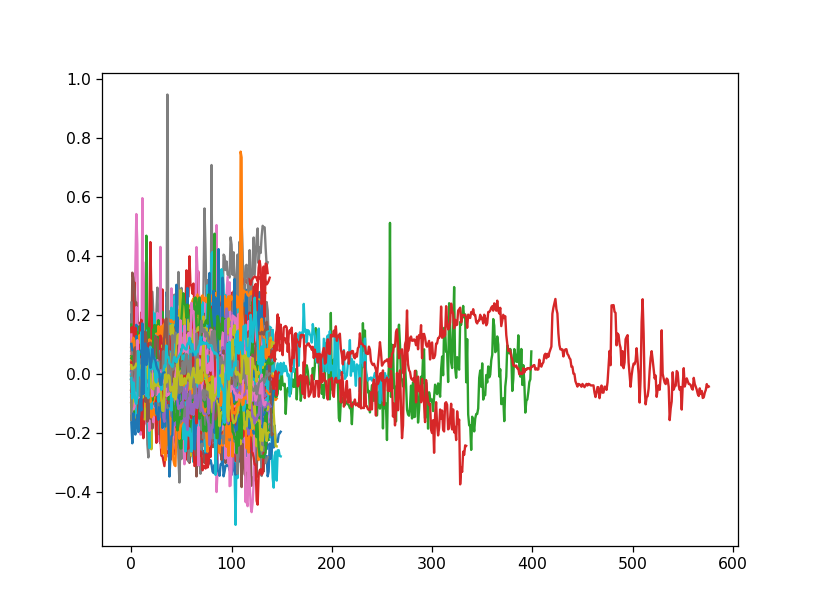

In [77]:
f,ax=plt.subplots(1,1)
for i in pureYvals:
    ax.plot(pureYvals[i])

### compare find_peaks_cwt using different scale vectors

Here, I made several side-by-side comparisons of parameter variations

<IPython.core.display.Javascript object>


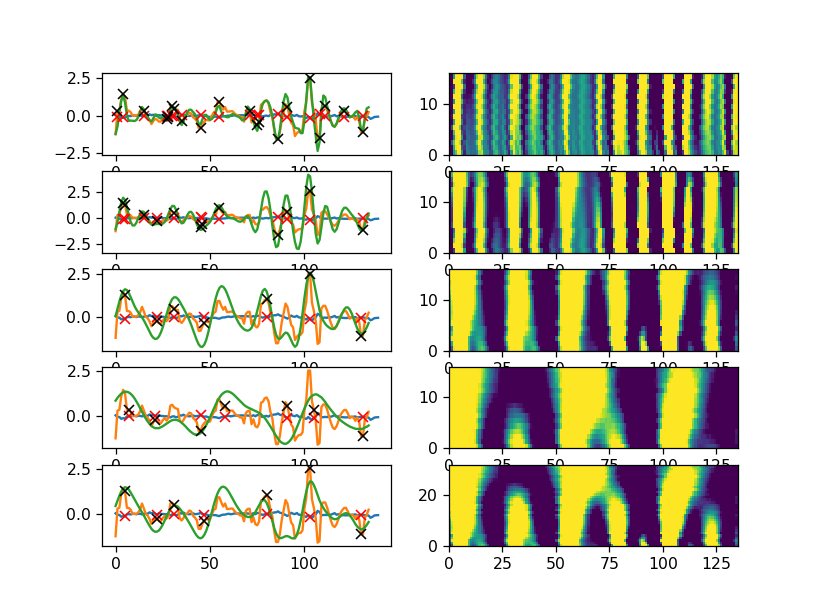

In [78]:
# compare find_peaks_cwt using different scale vectors
scaleParam = {0: 2.**np.arange(0, 1, 1./16.),
              1: 2.**np.arange(1, 2, 1./16.),
              2: 2.**np.arange(2, 3, 1./16.),
              3: 2.**np.arange(3, 4, 1./16.),
              4: 2.**np.arange(2, 4, 1./16.),
              #5: 2.**np.arange(0, 6, 1./16.)
             }
f,ax=plt.subplots(5,2)
start=0

for i,scales in scaleParam.items():
    y=pureYvals[2]
    detectSignal = signal.medfilt(y,3)
    #detectSignal=np.diff(detectSignal)
    detectSignal = central_diff_derivative(detectSignal, 0.05, 0.02)
    #detectSignal = np.abs(detectSignal)
    peaks = signal.find_peaks_cwt(detectSignal, scales, gap_thresh=1, window_size=20, noise_perc=5)
    peaks2 = signal.find_peaks_cwt(-detectSignal, scales, gap_thresh=1, window_size=15, noise_perc=5)
    peaks = np.concatenate((peaks,peaks2))
    #peaks = signal.find_peaks_cwt(y, scales, gap_thresh=3)
    #c,fs = pywt.cwt(y, scales, 'mexh', sampling_period=0.02)
    c,fs = pywt.cwt(detectSignal, scales, 'mexh', sampling_period=0.02)
    ax[i-start,0].plot(y)
    ax[i-start,0].plot(detectSignal)
    ax[i-start,0].plot(np.mean(c,axis=0))
    #if peaks.size==0:
    #    continue
    ax[i-start,0].plot(peaks, y[peaks], 'rx')
    ax[i-start,0].plot(peaks, detectSignal[peaks], 'kx')
    #ax[i-start,0].set_title(scales)
    im=ax[i-start,1].pcolormesh(c)
    im.set_clim([-0.5,0.5])
    

### detection

In [79]:
# get a random sample of trials to plot (visually inspect)
plotIdx = sorted(np.random.choice(np.arange(anlyz.segments.size), 8, replace=False))
plotIdx=np.append(plotIdx, anlyz.segments.size)#append a number that will never be reached later
#plotIdx=np.array([0,1,2,3,4,5,6,7,500])
plotIdx

array([ 12,  20,  42,  53,  81, 117, 153, 179, 181])

<IPython.core.display.Javascript object>


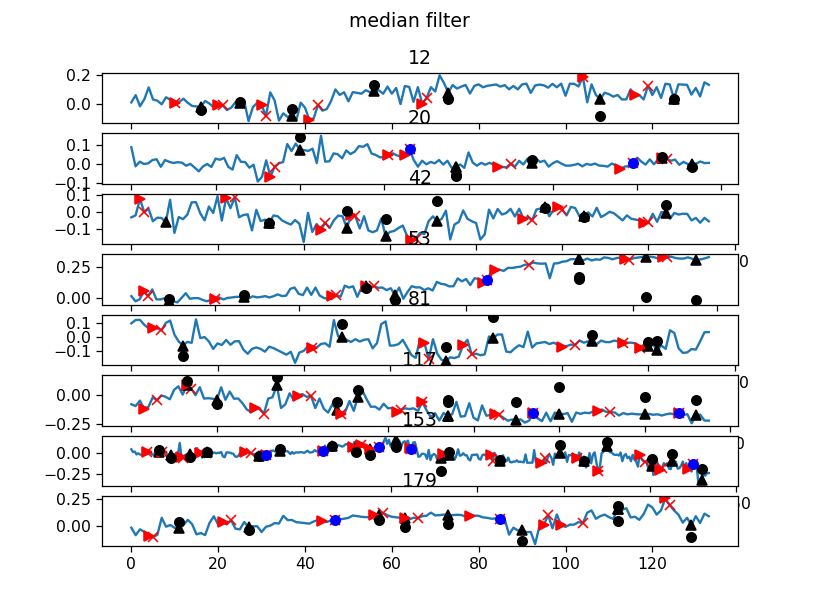

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  

Text(0.5, 0.98, 'median filter')

In [81]:
#scales = 2.**np.arange(0, 4, 1./16.)
saccDataCWT = {}
scales = 2.**np.arange(2, 3.5, 1./16.)
#f,ax=plt.subplots(5,2)
f,ax=plt.subplots(8,1)
ax=ax.reshape(-1,1)
#start=0
pltix=0
#for i in range(start,start+5):
for i in range(anlyz.segments.size):
#for i in [0]:
    y=pureYvals[i]
    detectSignal = signal.medfilt(y,5)
    #detectSignal=np.diff(detectSignal)
    detectSignal = central_diff_derivative(detectSignal, 0.05, 0.02)
    #peaks = signal.find_peaks_cwt(detectSignal, scales, gap_thresh=1, window_size=20, noise_p=5)
    peaks = signal.find_peaks_cwt(detectSignal, scales, gap_thresh=1, window_size=15, noise_perc=5)
    peaks2 = signal.find_peaks_cwt(-detectSignal, scales, gap_thresh=1, window_size=15, noise_perc=5)
    peaks = np.concatenate((peaks,peaks2))
    peaks = peaks.astype('int')
    #peaks = signal.find_peaks_cwt(y, scales, gap_thresh=3)
    #c,fs = pywt.cwt(y, scales, 'mexh', sampling_period=0.02)
    c,fs = pywt.cwt(detectSignal, scales, 'mexh', sampling_period=0.02)

    #peakTime = findPeakTimes(np.diff(signal.medfilt(y,5)), peaks)
    peakTime = findPeakTimes(detectSignal, peaks)+int(0.05/anlyz.kineflyPeriod)
    #onsetTime = findOnsetTime(np.diff(signal.medfilt(y,5)), peaks)
    onsetTime = findOnsetTime(np.diff(signal.medfilt(y,3)), peaks)
    saccAmp = getSaccadeAmplitude(y, peakTime, onsetTime, 1/anlyz.kineflyPeriod)
    #print(saccAmp)

    elim = eliminateByDeviation(y, onsetTime, saccAmp, 1/anlyz.kineflyPeriod, window=0.15, deviationLimit=0.65)
    keep = np.ones_like(peaks,dtype=np.bool)
    keep[elim]=False
    #print(sum(keep))
    
    theta = extractFlyStatistics(y, 1/anlyz.kineflyPeriod, plot=False)
    #print(theta)

    if i==plotIdx[pltix]:
        ax[pltix,0].plot(y)
        #ax[i-start,0].plot(detectSignal)
        ax[pltix,0].plot(peaks, y[peaks], 'rx')
        #ax[i-start,0].plot(peaks, detectSignal[peaks], 'kx')
        #im=ax[i-start,1].pcolormesh(c)
        #im.set_clim([-0.5,0.5])

        ax[pltix,0].plot(peakTime, y[peakTime], 'k^')
        ax[pltix,0].plot(onsetTime, y[onsetTime], 'r>')
        ax[pltix,0].plot(peakTime, saccAmp, 'ko')
        ax[pltix,0].plot(peaks[keep], y[peaks[keep]], 'o',color='b',markerfacecolor=None)
        ax[pltix,0].set_title(plotIdx[pltix])
        pltix += 1

    peaks = peaks[keep]
    peakTime = peakTime[keep]
    onsetTime = onsetTime[keep]
    saccAmp = saccAmp[keep]
    
    saccDataCWT[i] = dict([('peakTime',peakTime),('onset',onsetTime), ('saccAmp',saccAmp), ('CWTpeaks',peaks)])
f.suptitle('median filter')

### plot

In [82]:
saccDataCWT

{0: {'peakTime': array([78]),
  'onset': array([73]),
  'saccAmp': array([0.14701273]),
  'CWTpeaks': array([74])},
 1: {'peakTime': array([], dtype=int32),
  'onset': array([], dtype=int32),
  'saccAmp': array([], dtype=float64),
  'CWTpeaks': array([], dtype=int32)},
 2: {'peakTime': array([], dtype=int32),
  'onset': array([], dtype=int32),
  'saccAmp': array([], dtype=float64),
  'CWTpeaks': array([], dtype=int32)},
 3: {'peakTime': array([59]),
  'onset': array([44]),
  'saccAmp': array([0.29601053]),
  'CWTpeaks': array([47])},
 4: {'peakTime': array([], dtype=int32),
  'onset': array([], dtype=int32),
  'saccAmp': array([], dtype=float64),
  'CWTpeaks': array([], dtype=int32)},
 5: {'peakTime': array([95]),
  'onset': array([82]),
  'saccAmp': array([-0.15704602]),
  'CWTpeaks': array([83])},
 6: {'peakTime': array([], dtype=int32),
  'onset': array([], dtype=int32),
  'saccAmp': array([], dtype=float64),
  'CWTpeaks': array([], dtype=int32)},
 7: {'peakTime': array([], dtype=in

<IPython.core.display.Javascript object>


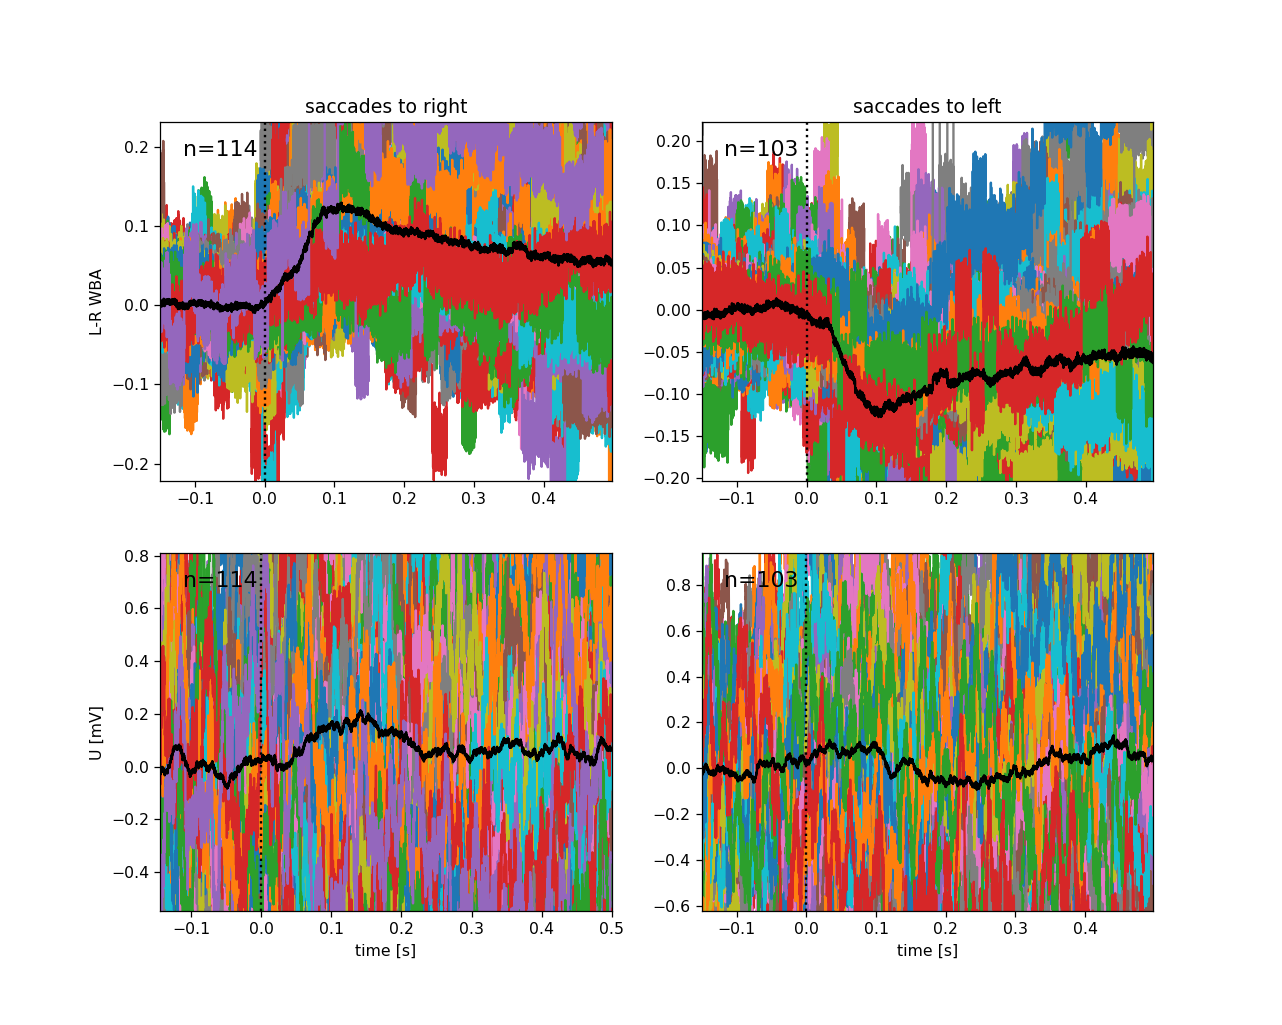

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean o

In [83]:
allLeft = []
allRight = []

f,ax=plt.subplots(2,2, figsize=(10,8))
#for el in range(10):
for el in range(len(anlyz)):
    if not isinstance(saccDataCWT[el]['peakTime'], (list,np.ndarray)):
        saccDataCWT[el] = {k:np.array([v]) for k,v in saccDataCWT[el].items()}
    if len(saccDataCWT[el]['peakTime'])==0:  continue
    v = saccDataCWT[el]
    #actualOnset= (v['onset']*anlyz.meanFramePeriod*anlyz.samplingRate).astype(int)
    actualOnset= (v['CWTpeaks']*0.02*anlyz.samplingRate).astype(int)
    #pdb.set_trace()
    saccAmp = v['saccAmp']
    rightSacc = []
    leftSacc=[]
    chunk = int(0.5*anlyz.samplingRate)
    preOnset = int(0.15*anlyz.samplingRate)
    ephys = anlyz.segments[el].data[0]*100.#ephys data
    wba = anlyz.segments[el].data[-1]
    #f,ax=plt.subplots(2,1, figsize=(10,4))
    #ax[0].plot(wba)
    #ax[1].plot(ephys)
    #for o,a in zip(actualOnset, saccAmp):
    for j in range(saccAmp.size):
        o=actualOnset[j]
        a=saccAmp[j]
        p= (v['peakTime']*0.02*anlyz.samplingRate).astype(int)[j]
        #ax[0].plot(o,wba[o], 'r>')
        #ax[0].plot(p, wba[p],'k^' )
        #xval = np.arange(o-preOnset, o+chunk)/anlyz.samplingRate
        if a<0:
            leftSacc.append(ephys[o-preOnset:o+chunk])
            d = wba[o-preOnset:o+chunk]
            xval = np.arange(-preOnset, d.size-preOnset)/anlyz.samplingRate
            ax[0,1].plot(xval, d-np.mean(d[:int(0.15*anlyz.samplingRate)]))#have to adjust this for PWC-fitted data
            d = ephys[o-preOnset:o+chunk]
            ax[1,1].plot(xval, d-np.mean(d[:int(0.15*anlyz.samplingRate)]))
        else:
            rightSacc.append(ephys[o-preOnset:o+chunk])
            d = wba[o-preOnset:o+chunk]
            xval = np.arange(-preOnset,d.size-preOnset)/anlyz.samplingRate
            ax[0,0].plot(xval, d-np.mean(d[:int(0.15*anlyz.samplingRate)]))#have to adjust this for PWC-fitted data
            d = ephys[o-preOnset:o+chunk]
            ax[1,0].plot(xval, d-np.mean(d[:int(0.15*anlyz.samplingRate)]))
    allLeft.extend(leftSacc)
    allRight.extend(rightSacc)
ax[0,0].set_title('saccades to right')
ax[0,1].set_title('saccades to left')
ax[0,0].set_ylabel('L-R WBA')
ax[1,0].set_ylabel('U [mV]')
ax[1,0].set_xlabel('time [s]')
ax[1,1].set_xlabel('time [s]')
#ax[0,0].set_ylim([-0.25, 0.51])
#ax[0,1].set_ylim([-0.51, 0.25])
#ax[1,0].set_ylim([-4, 4])
#ax[1,1].set_ylim([-4, 4])
#ax[0,0].set_ylim([-0.21, 0.45])
[a.set_xlim([-0.15,0.5]) for a in ax.flatten()]

[a.axvline(0., color='k', linestyle=':') for a in ax.flatten()]    

# post-hoc adding a mean
i=0
for a in ax.flatten():
    ally=[c.get_data()[1] for c in a.get_children() if isinstance(c, plt.Line2D)]
    ally=[y for y in ally if len(y)>100]
    #print([len(y) for y in ally])
    minLen = min([len(y) for y in ally])
    padLen = int(np.max([len(y) for y in ally]))
    #print(minLen)
    ally = [np.pad(y,(0,padLen-len(y)), mode='constant', constant_values=np.nan) for y in ally]
    #ally = np.array([y[:minLen] for y in ally])
    ally = np.array(ally)
    a.plot(np.arange(-preOnset,ally.shape[1]-preOnset)/anlyz.samplingRate, np.nanmean(ally,axis=0), 'k-')

    if i==0:
        anlyz.saccRightMeanWBA = np.nanmean(ally,axis=0)
    elif i==1:
        anlyz.saccLeftMeanWBA = np.nanmean(ally,axis=0)
    elif i==2:
        anlyz.saccRightMeanEphys = np.nanmean(ally,axis=0)
    elif i==3:
        anlyz.saccLeftMeanEphys = np.nanmean(ally,axis=0)
    i+=1
    #a.set_xlim([-preOnset,padLen/anlyz.samplingRate])
    a.text(0.05, 0.95, f'n={ally.shape[0]}', transform=a.transAxes, fontsize=14,
    verticalalignment='top')

In [63]:
padLen

9750

### save results

In [92]:
f.savefig(os.path.join(DATAPATH,'spontaneousSaccades','CWTdetection', anlyz.flyID[0]+'_looming_wb_spontSaccades.png' ))
f.savefig(os.path.join(DATAPATH,'spontaneousSaccades','CWTdetection', anlyz.flyID[0]+'_looming_wb_spontSaccades.svg' ))

In [93]:
# split into saccades left and right
# make use of the mechanism for splitting flying or not
anlyz.saccades = saccDataCWT
anlyz.write2neomatfile(os.path.join(DATAPATH,'spontaneousSaccades','CWTdetection', anlyz.flyID[0]+'_looming_wb_spontSaccades_cwtDetection.neomat'))


## by manual inspection
This can act as a "ground truth" for comparing algorithms as well.

In [33]:
import ipywidgets
import plotly.graph_objects as go
#slider = ipywidgets.IntSlider(min=0, max=len(detectSignal)-1)
intBox = ipywidgets.BoundedIntText( value=0, min=0, max=anlyz.segments.size, step=1, description='segment Nr:', disabled=False)
trace1a = go.Scatter(y=anlyz.segments[0].data[-1], name='L-R WBA')
trace1b = go.Scatter(y=anlyz.segments[0].data[1], name='wingL')
trace1c = go.Scatter(y=anlyz.segments[0].data[2], name='wingR')
trace2 = go.Scatter(y=helperLibrary.straightLineFiltering(anlyz.segments[0].data[-1], 0.020*anlyz.samplingRate, postEnhancement=True)[0], name='WBA PWC fit')
"""fig = go.FigureWidget(data=[trace1, trace2],
            layout=go.Layout(
                title=dict(
                    text='filtered and differentiated signals') ))
def react(change):
    idx = slider.value
    fig.data[0].y = pureYvals[idx]
    fig.data[1].y = detectSignal[idx]
    return
"""
fig1 = go.FigureWidget(data=[trace1a,trace1b,trace1c, trace2],
            layout=go.Layout(
                title=dict(text='L-R WBA') ))
def react(change):
    #idx = slider.value
    idx = intBox.value
    fig1.data[0].y =anlyz.segments[idx].data[-1]
    fig1.data[1].y =anlyz.segments[idx].data[1]
    fig1.data[2].y =anlyz.segments[idx].data[2]
    fig1.data[3].y = helperLibrary.straightLineFiltering(anlyz.segments[idx].data[-1], 0.020*anlyz.samplingRate, postEnhancement=True)[0]
    return

#slider.observe(react, names='value')
intBox.observe(react, names='value')
#container = ipywidgets.widgets.HBox([slider])
container = ipywidgets.widgets.HBox([intBox])
ipywidgets.widgets.VBox([container,
              fig1])

  …

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



In [29]:
saccadesManual

{0: [13355, 16543, 18149],
 1: [3648, 5829, 21242],
 2: [21058, 22260],
 3: [23840],
 4: [8806, 20408],
 5: [2621, 6430, 16427, 24433],
 6: [24095],
 7: [3428, 11841, 21225],
 8: [4063, 21066],
 9: [4330, 6540, 22541],
 10: [2280, 6469, 26082],
 11: [4668, 6662, 16054, 17667],
 12: [25254],
 13: [],
 14: [10132],
 15: [7498, 16694, 26293],
 16: [6283],
 17: [10437],
 18: [12368],
 19: [],
 20: [10500, 22644],
 21: [3233, 24237],
 22: [1960, 6962, 8554, 15358],
 'notes': 'less saccades an generally lower amplitude in segments 11-21',
 'flyID': {0: 'fly1_Looming_20180725_cell1'},
 'files': {0: 'Fly1_WTCS_age_3d_cell1_Looming_wb_2018_07_25_10_24_02.mat'}}

In [158]:
print(saccData[2])

{'peakTime': array([ 1571,  2817,  4658,  7285,  9447, 10650, 14021, 14021, 17597,
       18605, 20530, 22218, 23423, 27611], dtype=int64), 'actualOnset': array([  500,  1571,  2817,  6319,  7285,  9447, 11030, 11030, 15867,
       17597, 19444, 20530, 22218, 26204], dtype=int64), 'saccAmp': array([-0.00953843,  0.01344146, -0.01663281,  0.01721185, -0.01615207,
        0.02545637, -0.00321432, -0.02451075, -0.03313407, -0.1590859 ,
        0.01502812,  0.01801688, -0.10598064, -0.0054781 ])}


### extract amplitudes

In [35]:
saccAmplitude = dict()
for seg, sacclist in saccadesManual.items():
#for seg,sacclist in ((22, saccadesManual[22]),):
    if not isinstance(seg, int):
        continue
    amps = []
    d = anlyz.segments[seg].data[-1]
    longd, xsteps, d = helperLibrary.straightLineFiltering(d, 0.020*anlyz.samplingRate, postEnhancement=True)
    
    f,ax=plt.subplots(1,1)
    ax.plot(anlyz.segments[seg].data[-1])
    ax.plot(longd)
    #ax.plot(np.diff(longd))
    
    for sacc in sacclist:
        whichX = np.where(np.diff((xsteps-sacc+10)>0))[0][0]
        #print(np.where(np.diff((xsteps-sacc)>0)))
        #np.where(np.diff(d[whichX:])
        i=whichX
        samesign = True
        dd = np.diff(d)
        while samesign:
            i+=1
            samesign = dd[i-1]*dd[i] >0.
        baseline = np.mean(d[whichX-3:whichX])
        a = d[i]-baseline
        amps.append(a)
        
        ax.axvline(sacc)
        ax.axhline(longd[sacc])
        ax.axvline(xsteps[whichX]+50, color='k')
        ax.axhline(d[whichX], color='k')
        ax.axvline(xsteps[i]+50, color='r')
        ax.axhline(d[i], color='r')
        ax.axhline(baseline, color='g')

    saccAmplitude[seg] = amps
    
    #saccAmplitude = getSaccadeAmplitude(d, sacclist, anlyz.samplingRate)
    #peakTime = findPeakTimes(np.diff(signal.medfilt(d,101)), [sacclist])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



In [36]:
plt.close('all')

### look at result

In [78]:
#for el,v in saccData.items():
#for el in [22]:
f,ax=plt.subplots(2,2)
alldata_left=[]
alldata_right=[]
for el in saccadesManual:
    if not isinstance(el, int):  continue
    #v = saccadesManual[el]
    #actualOnset= v['actualOnset']
    actualOnset = saccadesManual[el]
    print(actualOnset)
    #saccAmp = v['saccAmp']
    saccAmp = saccAmplitude[el]
    rightSacc = []
    leftSacc=[]
    chunk = int(0.5*anlyz.samplingRate)
    preOnset = int(0.25*anlyz.samplingRate)
    ephys = anlyz.segments[el].data[0]#ephys data
    wba = anlyz.segments[el].data[-1]
    for o,a in zip(actualOnset, saccAmp):
        if np.abs(a)<0.10:   continue
        if o-preOnset<0 :  continue
        if a<0:
            #d = ephys[o-preOnset:o+chunk]-np.mean(ephys[o-preOnset:o-preOnset+400])
            d = ephys[o-preOnset:o+chunk]
            alldata_left.append(d)
            leftSacc.append(ephys[o-preOnset:o+chunk])
            ax[0,1].plot(wba[o-preOnset:o+chunk]-np.mean(wba[o-preOnset:o-200]))#have to adjust this for PWC-fitted data
            #ax[1,1].plot(ephys[o-preOnset:o+chunk]-np.mean(ephys[o-preOnset:o-200]))
            ax[1,1].plot(d)
        else:
            #d = ephys[o-preOnset:o+chunk]-np.mean(ephys[o-preOnset:o-preOnset+400])
            d = ephys[o-preOnset:o+chunk]
            alldata_right.append(d)
            rightSacc.append(ephys[o-preOnset:o+chunk])
            ax[0,0].plot(wba[o-preOnset:o+chunk]-np.mean(wba[o-preOnset:o-200]))#have to adjust this for PWC-fitted data
            ax[1,0].plot(d)
    ax[0,0].set_title('saccades to right')
    ax[0,1].set_title('saccades to left')
    ax[0,0].set_ylabel('L-R WBA')
    ax[1,0].set_ylabel('U [mV]')
    [a.axvline(preOnset, color='k', linestyle=':') for a in ax.flatten()]

<IPython.core.display.Javascript object>

NameError: name 'saccadesManual' is not defined

In [57]:
# add an average line
allLeft = np.array([ np.pad(l, (0,(preOnset+chunk)-l.size), constant_values=np.nan) for l in alldata_left])
#ax[1,1].plot(np.nanmean(allLeft-np.mean(allLeft[:,:500],axis=1).reshape(-1,1), axis=0), 'k-')
ax[1,1].plot(np.nanmean(allLeft, axis=0), 'k-')
allRight = np.array([ np.pad(l, (0,(preOnset+chunk)-l.size), constant_values=np.nan) for l in alldata_right])
#ax[1,0].plot(np.nanmean(allRight-np.mean(allRight[:,:500],axis=1).reshape(-1,1), axis=0), 'k-')
ax[1,0].plot(np.nanmean(allRight, axis=0), 'k-')

In [157]:
manualWay = {'onsets': saccadesManual, 'amplitudes': saccAmp}
import pickle
with open('manualSaccadeSorting_'+anlyz.fileOrigin[0]+'210416.pickle', 'wb') as f:
    pickle.dump( manualWay, f)